<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/Week7/Assignment/MSDS453_Assignment_03_v25_20231025_KG_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
!python -m spacy download en_core_web_lg -q

2023-11-05 13:59:44.135461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 13:59:44.135512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 13:59:44.135550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 13:59:47.542588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [5]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [6]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [7]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [9]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [10]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [12]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [13]:
CORPUS_PATH=\
'/content/gdrive/MyDrive/Temp/MSDS453/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [14]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Tokenize Words

In [15]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, outnumber, outgunne, mike, b...
91    [sleepy, dopey, action, bonanza, angel, fall, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [improve, blandness, mike, banning, gerard, bu...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

In [16]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Reassemble Leminized Words

In [17]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [18]:
corpus_df['lemmas_joined'].head()

Doc_ID
90    target heavily outnumber outgunne mike banning...
91    sleepy dopey action bonanza angel fall disappo...
92    angel fall mark time gerard butler secret serv...
93    improve blandness mike banning gerard butler w...
94    review contain spoiler angel fallen movie extr...
Name: lemmas_joined, dtype: object

In [19]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Vocabulary Data Wrangling

In [20]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 8802
Curated Vocabulary size: 1774


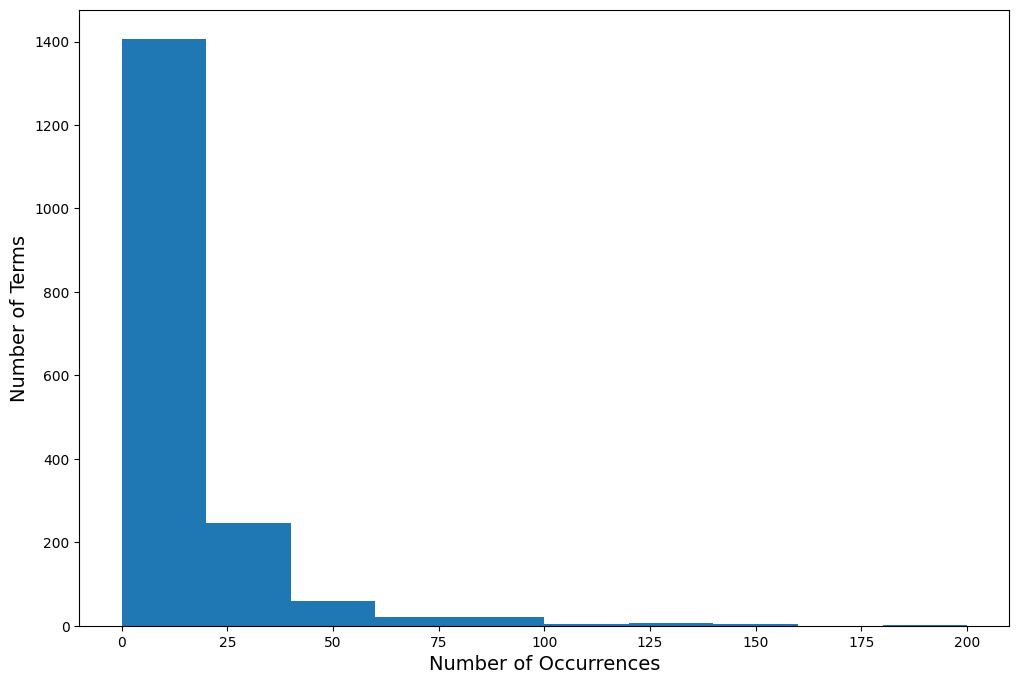

In [21]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [22]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, mike, banning, gerard, butle...
91    [action, angel, fall, reason, expect, second, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [mike, banning, gerard, butler, accept, promot...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [23]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [24]:
corpus_df.head().T

Doc_ID,90,91,92,93,94
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...,This review may contain spoilers . Angel Has F...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93,Action_Angel_has_fallen_N_94
Doc_ID,90,91,92,93,94
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin...","[This review may contain spoilers ., Angel Has..."


## Review Documents By Movie Title

In [25]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [26]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Taxi'].copy()
movie_df.head(3).T

Doc_ID,65,66,67
DSI_Title,VGI_Doc6_Taxi,VGI_Doc7_Taxi,VGI_Doc8_Taxi
Text,This is quite simply the french version of US ...,This has to be the biggest pile of pap i have ...,"When I rented this movie , I expected it to be..."
Submission File Name,VGI_Doc6_Taxi,VGI_Doc7_Taxi,VGI_Doc8_Taxi
Student Name,VGI,VGI,VGI
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Taxi,Taxi,Taxi
Descriptor,Action_Taxi_N_65,Action_Taxi_N_66,Action_Taxi_N_67
Doc_ID,65,66,67
raw_sentences,[This is quite simply the french version of US...,[This has to be the biggest pile of pap i have...,"[When I rented this movie , I expected it to b..."


## Knowledge Graph Extraction

In [52]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]

In [172]:
example_sentence = nlp(corpus_text_sentences[22])

In [173]:
displacy.render(example_sentence, style="dep", jupyter = True)

In [174]:
displacy.render(example_sentence, style="ent", jupyter = True)

In [153]:
len(corpus_text_sentences)

224

In [175]:
corpus_text_sentences[0]

'This is quite simply the french version of US blockbuster car movies .'

In [176]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 224/224 [00:02<00:00, 83.46it/s]


In [177]:
entity_pairs

[['This', 'french blockbuster car movies'],
 ['horrible  they', 'territory'],
 ['stupidity', '11'],
 ['minutes  brain', 'me'],
 ['that', 'movie'],
 ['few car mooks', 'Angelina skirt'],
 ['middle  it', 'brain'],
 ['dreamy jaw cars', 'Peugeot'],
 ['you', 'right'],
 ['', ''],
 ['that', 'everywhere tackiest Transformer'],
 ['I', ''],
 ["'s", 'par  performance'],
 ['', ''],
 ['french hip which', 'American  equivalent'],
 ['any  it', 'wel'],
 ['It', ''],
 ['they', 'sequels'],
 ['apart  it', 'french  SUPERcars'],
 ['years  I', 'years  which'],
 ['I', ''],
 ['I', 'Jackie Thunderbolt'],
 ['when Corben you', 'real  thing'],
 ['', 'good  action'],
 ['plot', 'comic book this'],
 ['same  which', 'same  Subway'],
 ['Childish  comedy', 'million  story'],
 ['Fast  saga', 'car capabilities'],
 ['how  they', '4  disaster'],
 ['biggest  i', 'ever  life'],
 ['', 'it'],
 ['I', 'kecks'],
 ['very  this', 'film'],
 ['you', 'fear'],
 ['earth', 'gene pool'],
 ['Big God', 'soul'],
 ['sooner  i', 'you'],
 ['kind'

### Create DataFrame (Source, Target, Edge)

In [178]:
relations = [get_relation(x) for x in corpus_text_sentences]
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [179]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.source != kg_df.target]

In [180]:
kg_df.head(6).T

,0,1,2,3,4,5
source,this,horrible they,stupidity,minutes brain,that,few car mooks
target,french blockbuster car movies,territory,11,me,movie,angelina skirt
edge,is,go with,goes to,tried,'s,are


In [181]:
kg_df.shape

(179, 3)

In [182]:
len(corpus_text_sentences)

224

In [183]:
kg_df_temp = pd.DataFrame({'source': kg_df['source'], 'edge': kg_df['edge'], 'target': kg_df['target'] })
kg_df_temp.to_excel("kg_ex1.xlsx")
kg_df_temp

,source,edge,target
0,this,is,french blockbuster car movies
1,horrible they,go with,territory
2,stupidity,goes to,11
3,minutes brain,tried,me
4,that,'s,movie
...,...,...,...
216,he,discovers,top speed ride
217,that,ends,german bank robbers
218,you,be,that
219,well she,stars,well uk


In [184]:
# Perform custom cleaning before plotting knowledge graphs
source_list = ['']
target_list = ['11']
edge_list =['\'s']

for item in source_list:
  kg_df = kg_df[kg_df.source != item]

for item in target_list:
  kg_df = kg_df[kg_df.target != item]

for item in edge_list:
  kg_df = kg_df[kg_df.edge != item]

In [185]:
kg_df

,source,target,edge
0,this,french blockbuster car movies,is
1,horrible they,territory,go with
3,minutes brain,me,tried
5,few car mooks,angelina skirt,are
7,dreamy jaw cars,peugeot,are
...,...,...,...
216,he,top speed ride,discovers
217,that,german bank robbers,ends
218,you,that,be
219,well she,well uk,stars


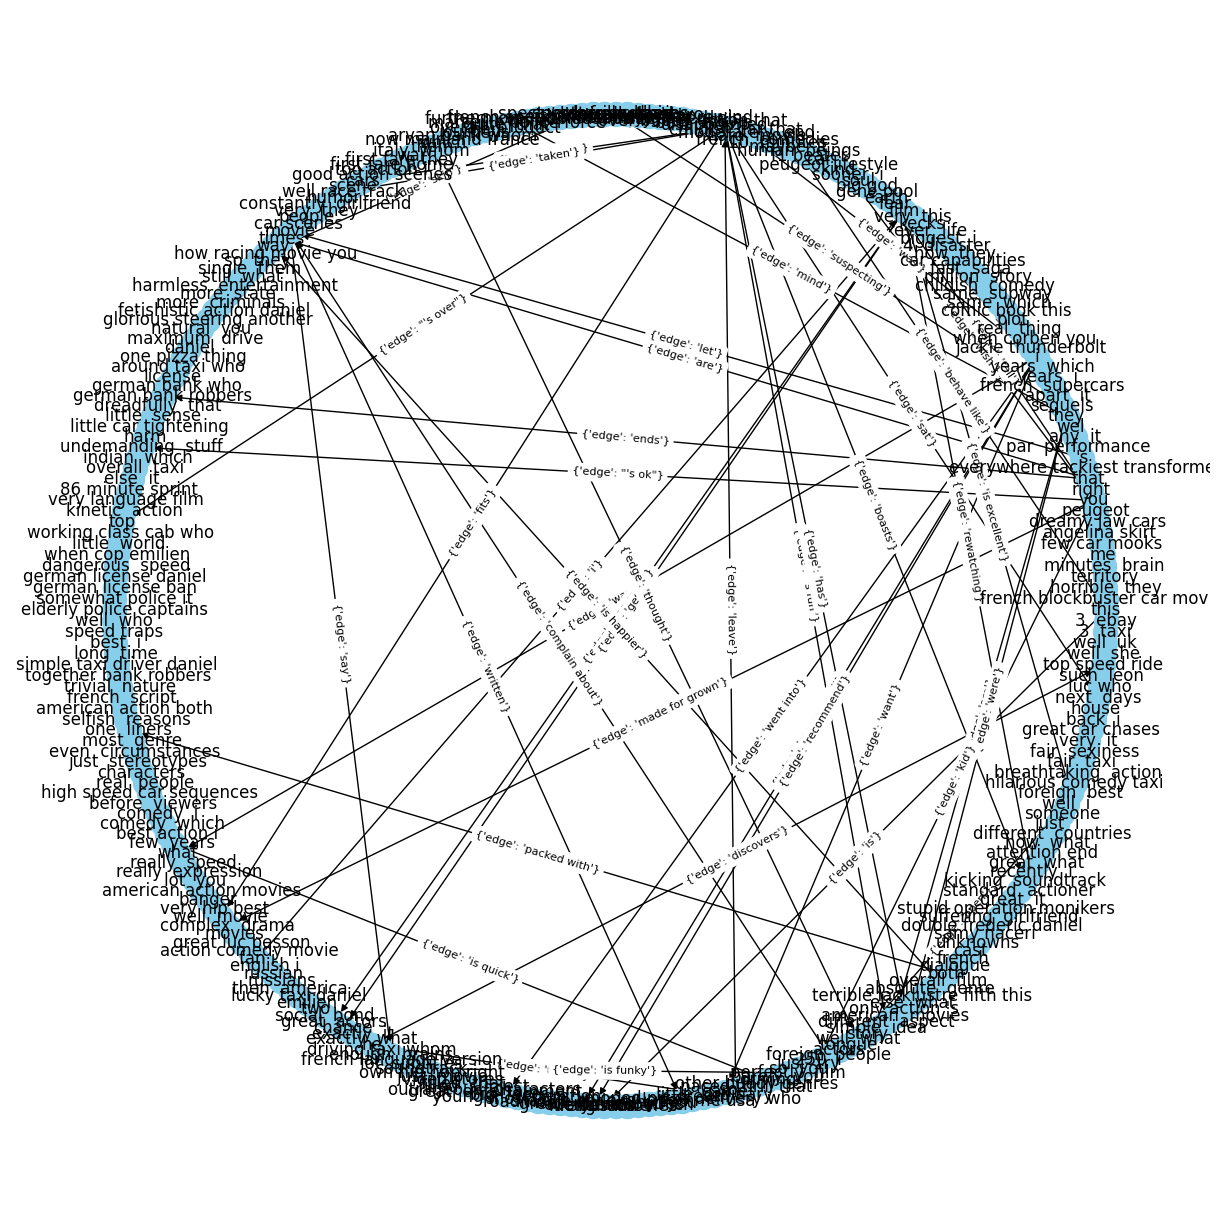

In [186]:
plot_graph(kg_df, use_circular=True, show_edges=True)

### Top 10 source, target, and edge parameters

In [187]:
kg_df['source'].value_counts().nlargest(10)

it            9
i             9
you           5
they          4
film          3
movie         3
he            3
that          3
soundtrack    2
this          2
Name: source, dtype: int64

In [188]:
kg_df['target'].value_counts().nlargest(10)

film                   4
movie                  3
it                     2
you                    2
way                    2
well  what             2
german bank robbers    2
cars                   2
what                   2
few  years             2
Name: target, dtype: int64

In [189]:
kg_df['edge'].value_counts().nlargest(10)

is             28
are             8
has             5
recommend       4
get             3
want            2
consists of     2
give            2
was             2
wish            2
Name: edge, dtype: int64

### Plot graphs for top 5 source items

In [190]:
kg_df[kg_df['source']=='it']

,source,target,edge
57,it,stunning car rewind,has
74,it,cars,knew
76,it,well race track,taken
99,it,top,'s over
121,it,well movie,fits
178,it,different aspect,'s fun
183,it,only action 's,has
194,it,kicking soundtrack,boasts
213,it,next days,sat


Plotting knowledge graph of "source" token "it":


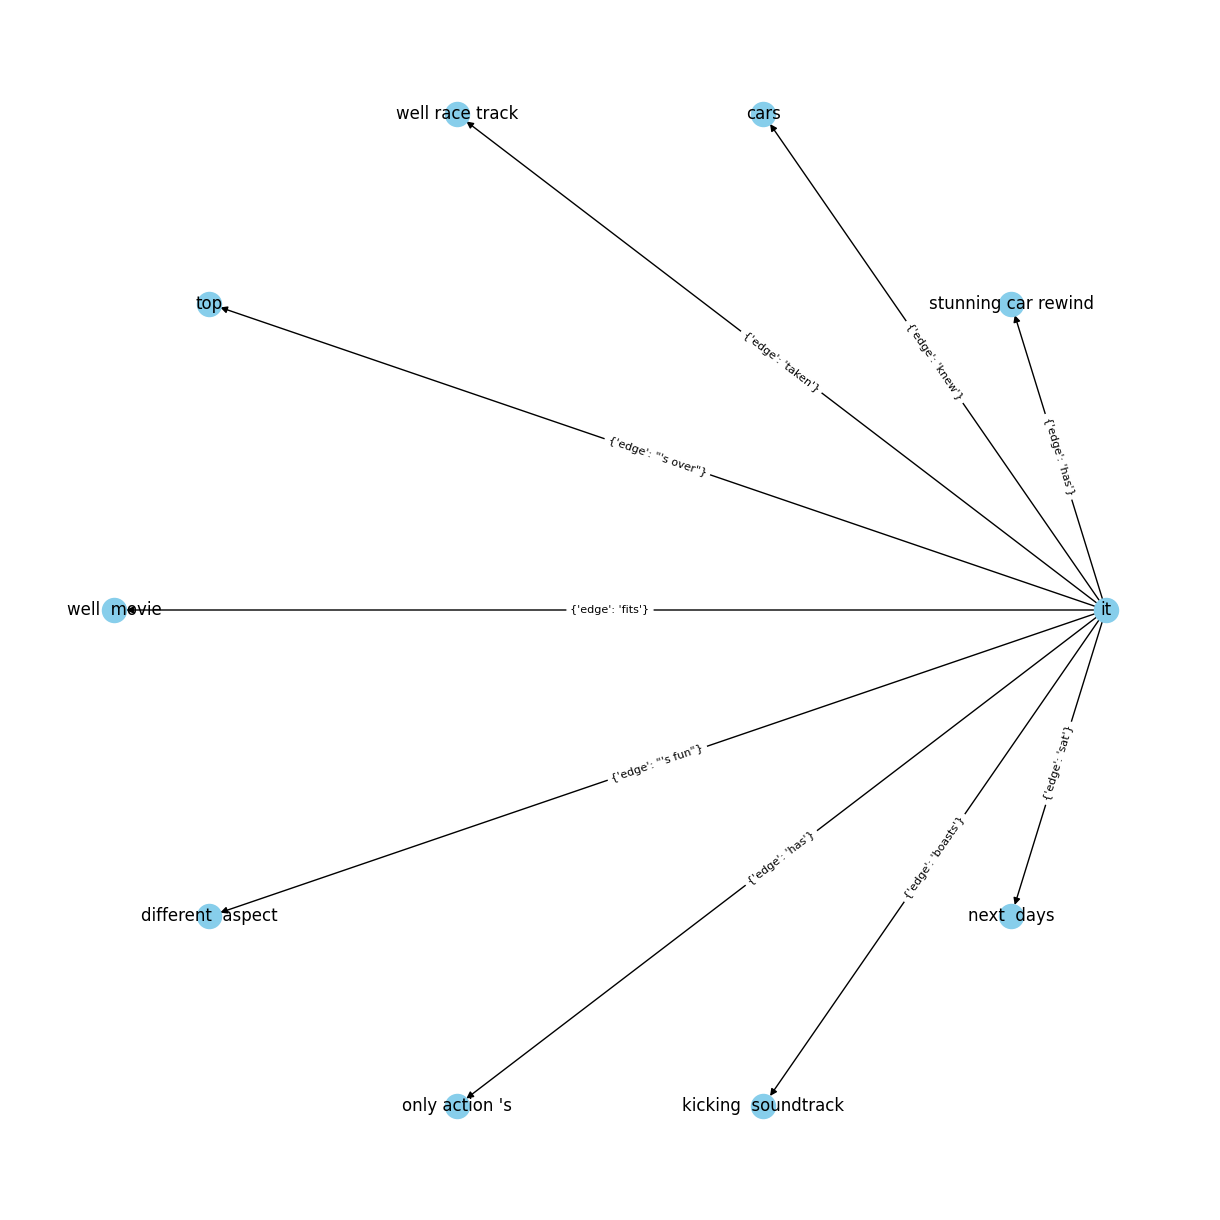

Plotting knowledge graph of "source" token "i":


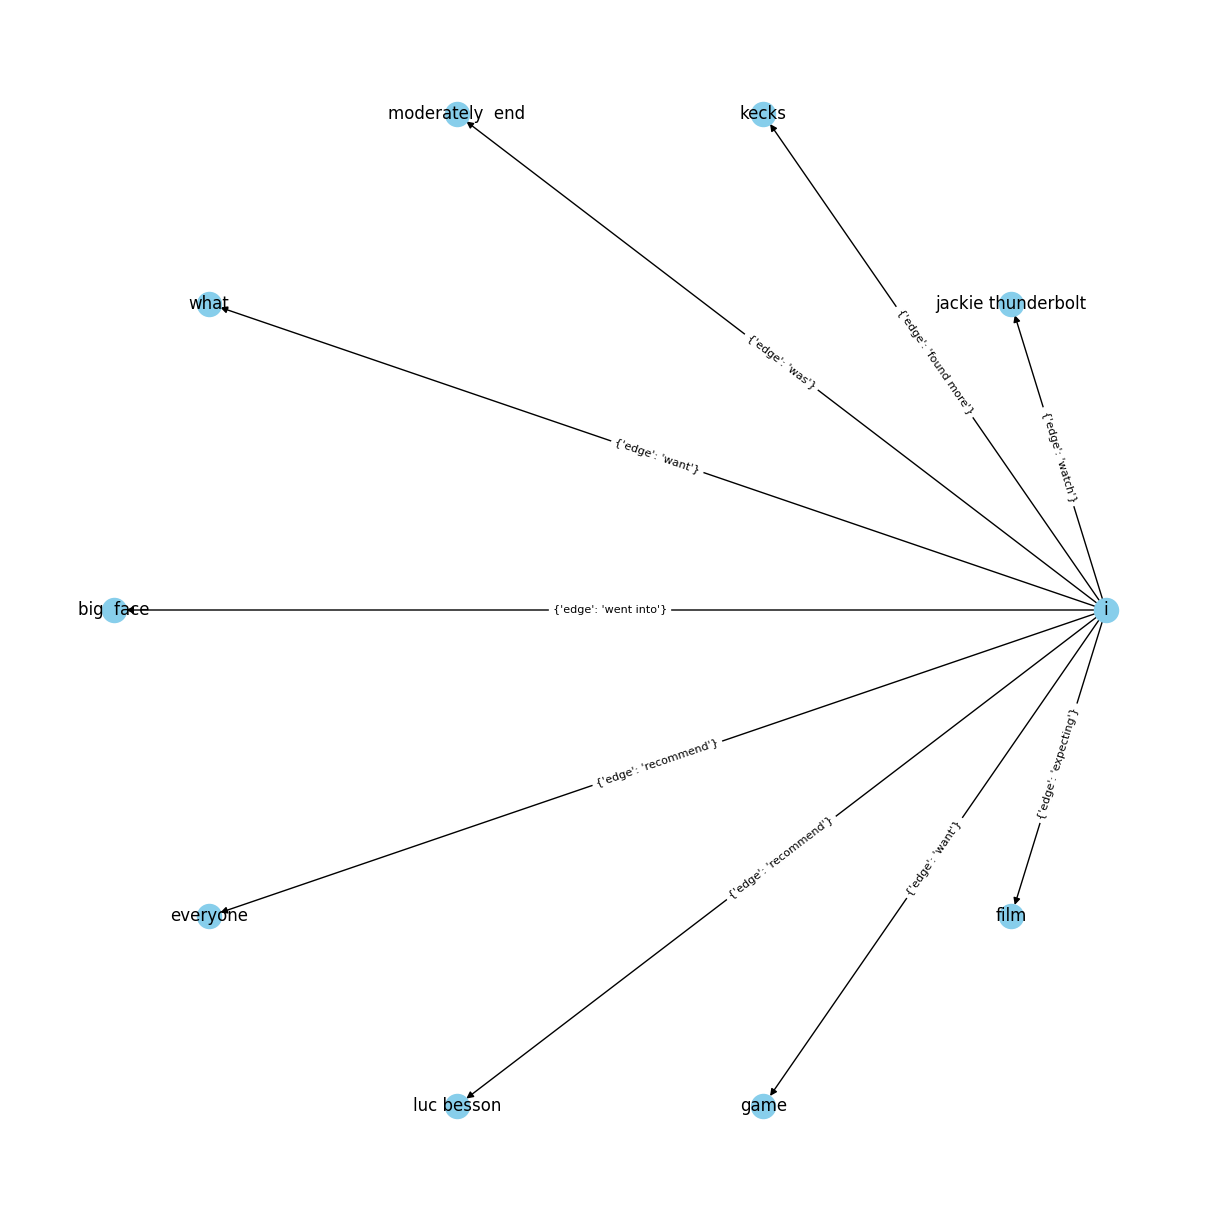

Plotting knowledge graph of "source" token "you":


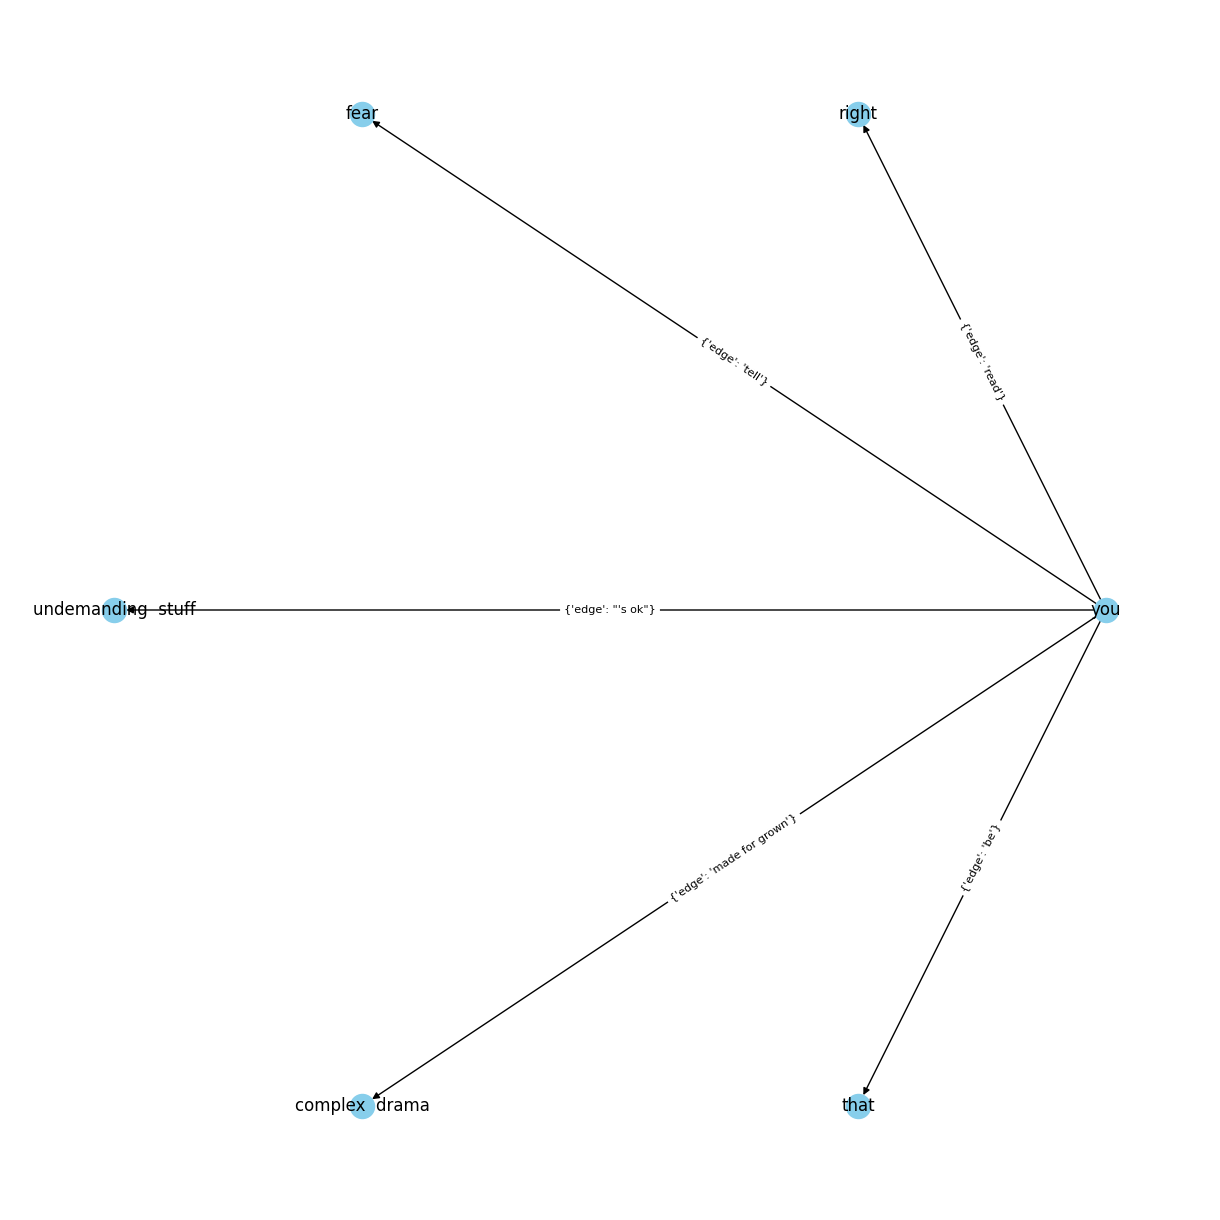

Plotting knowledge graph of "source" token "they":


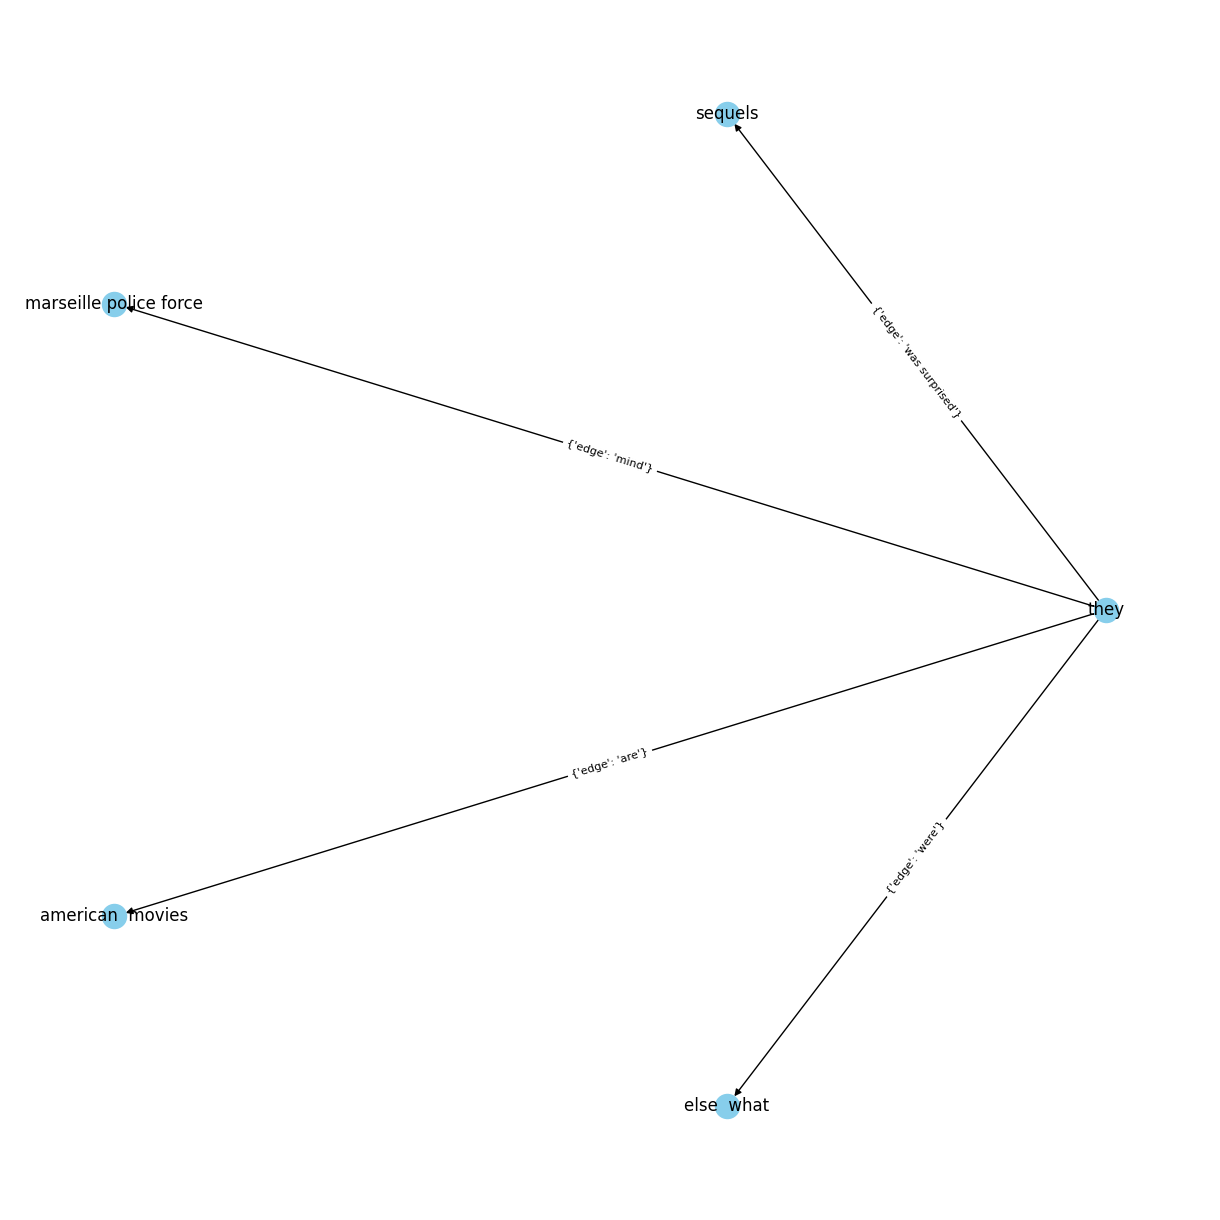

Plotting knowledge graph of "source" token "film":


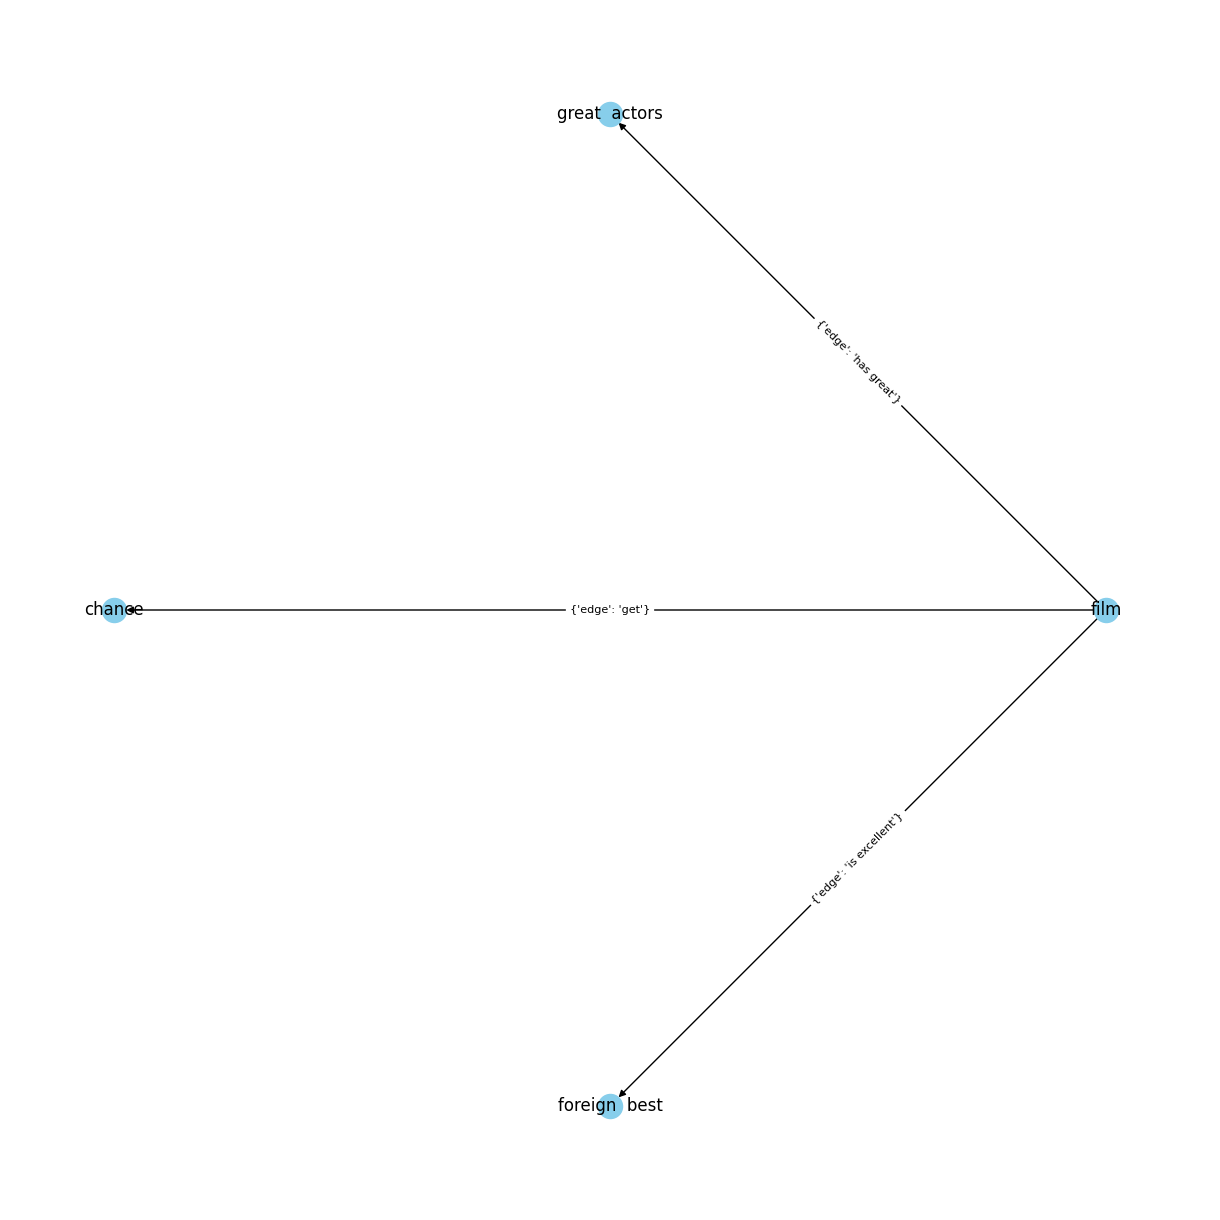

Plotting knowledge graph of "source" token "movie":


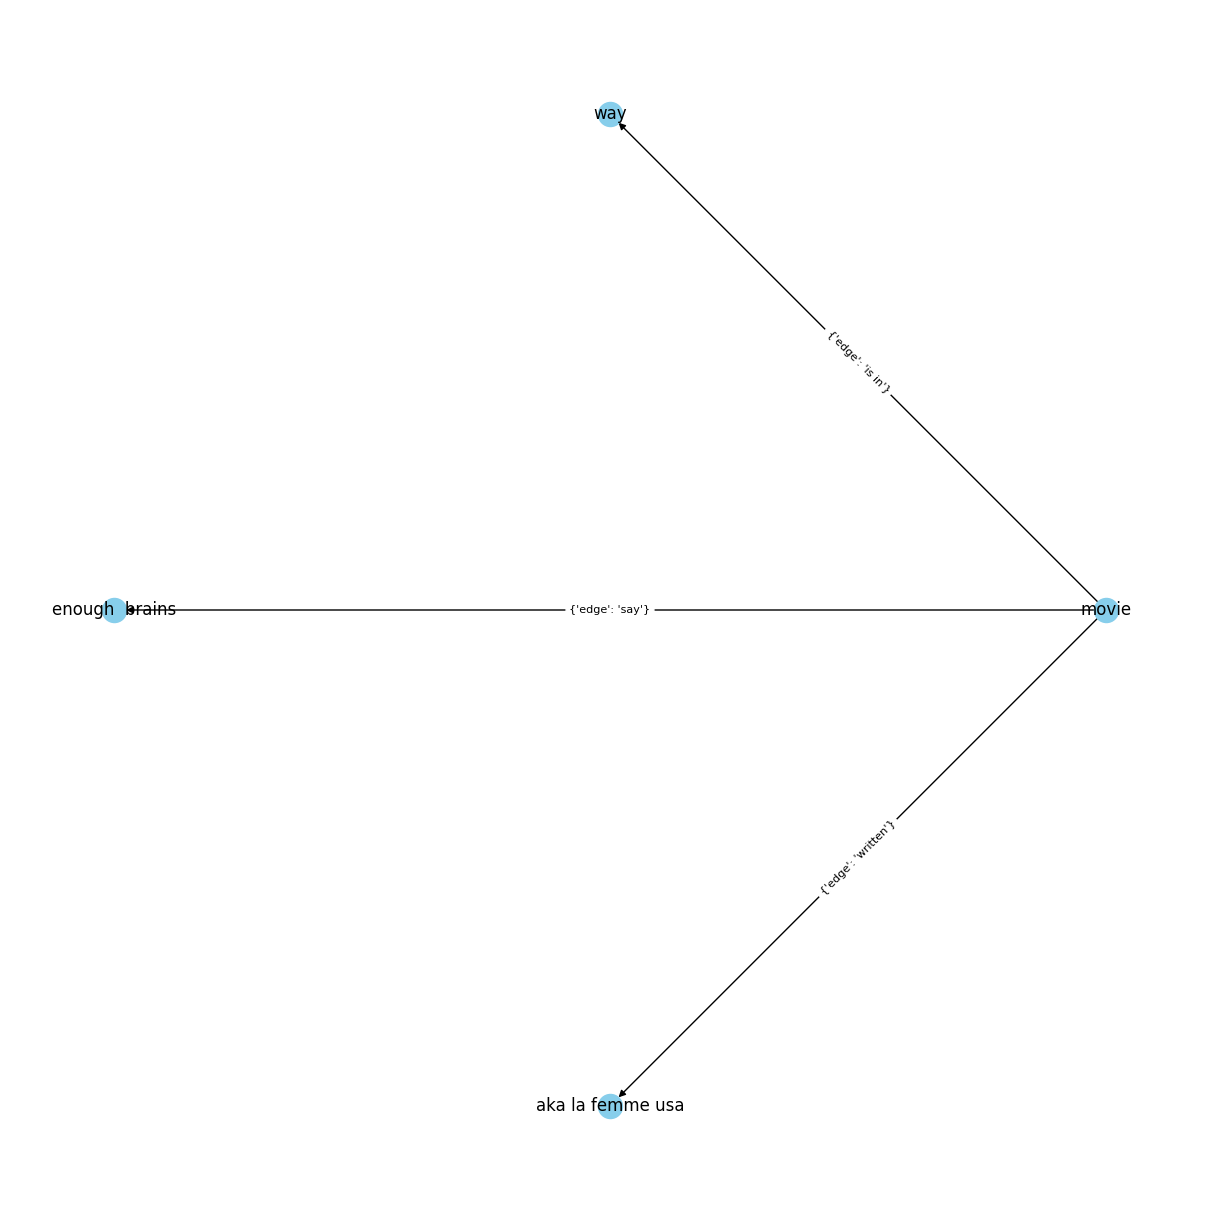

Plotting knowledge graph of "source" token "he":


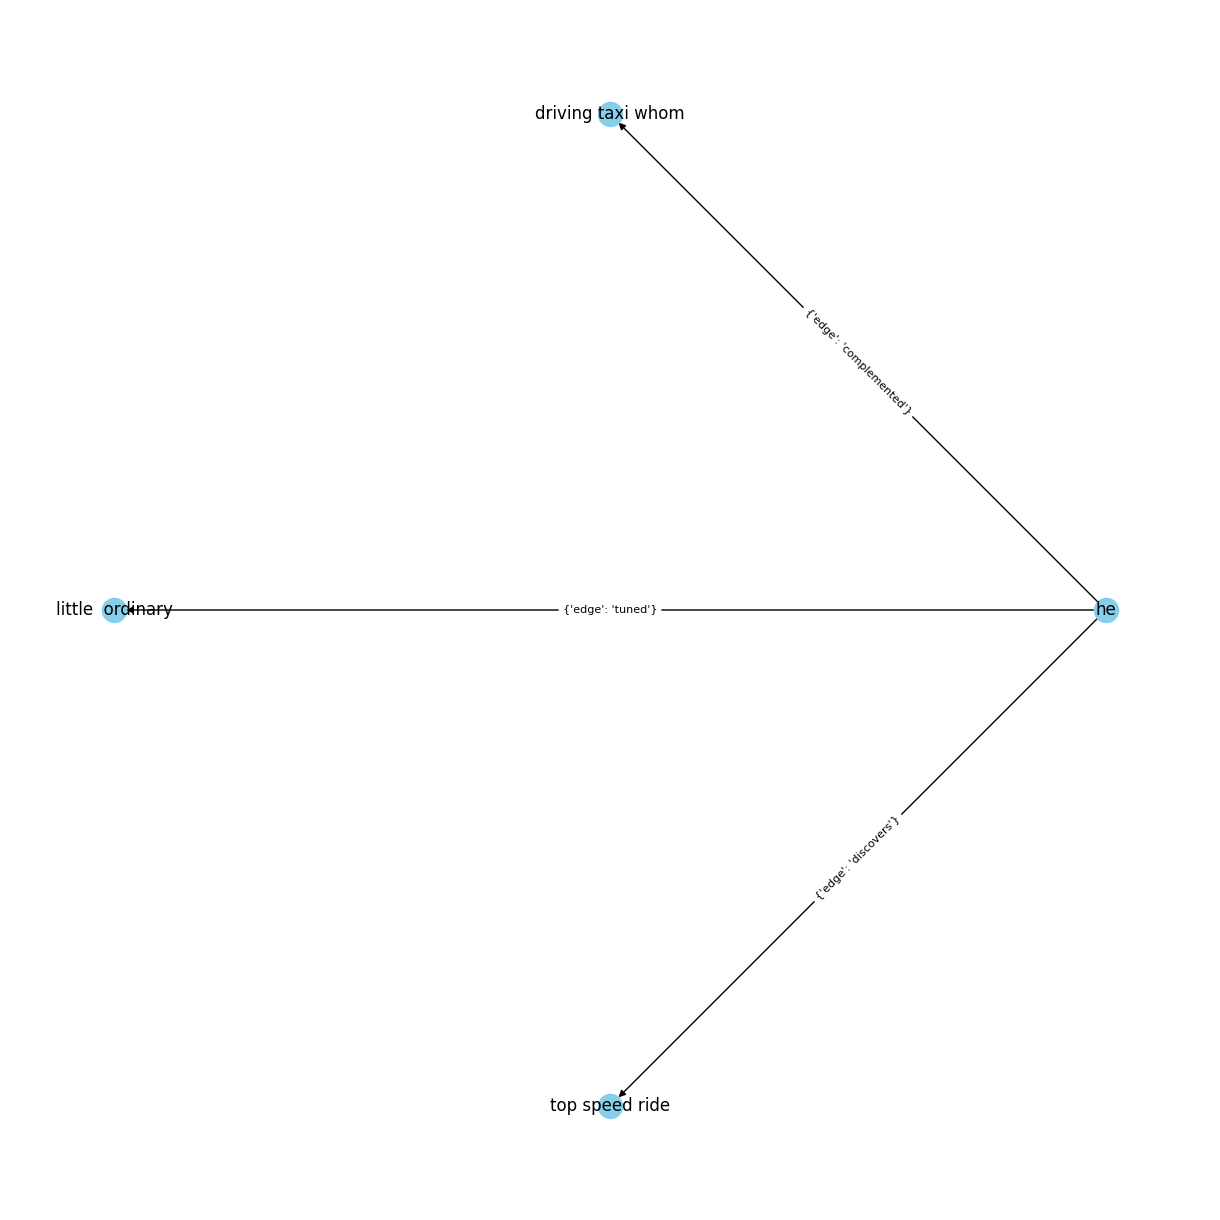

Plotting knowledge graph of "source" token "that":


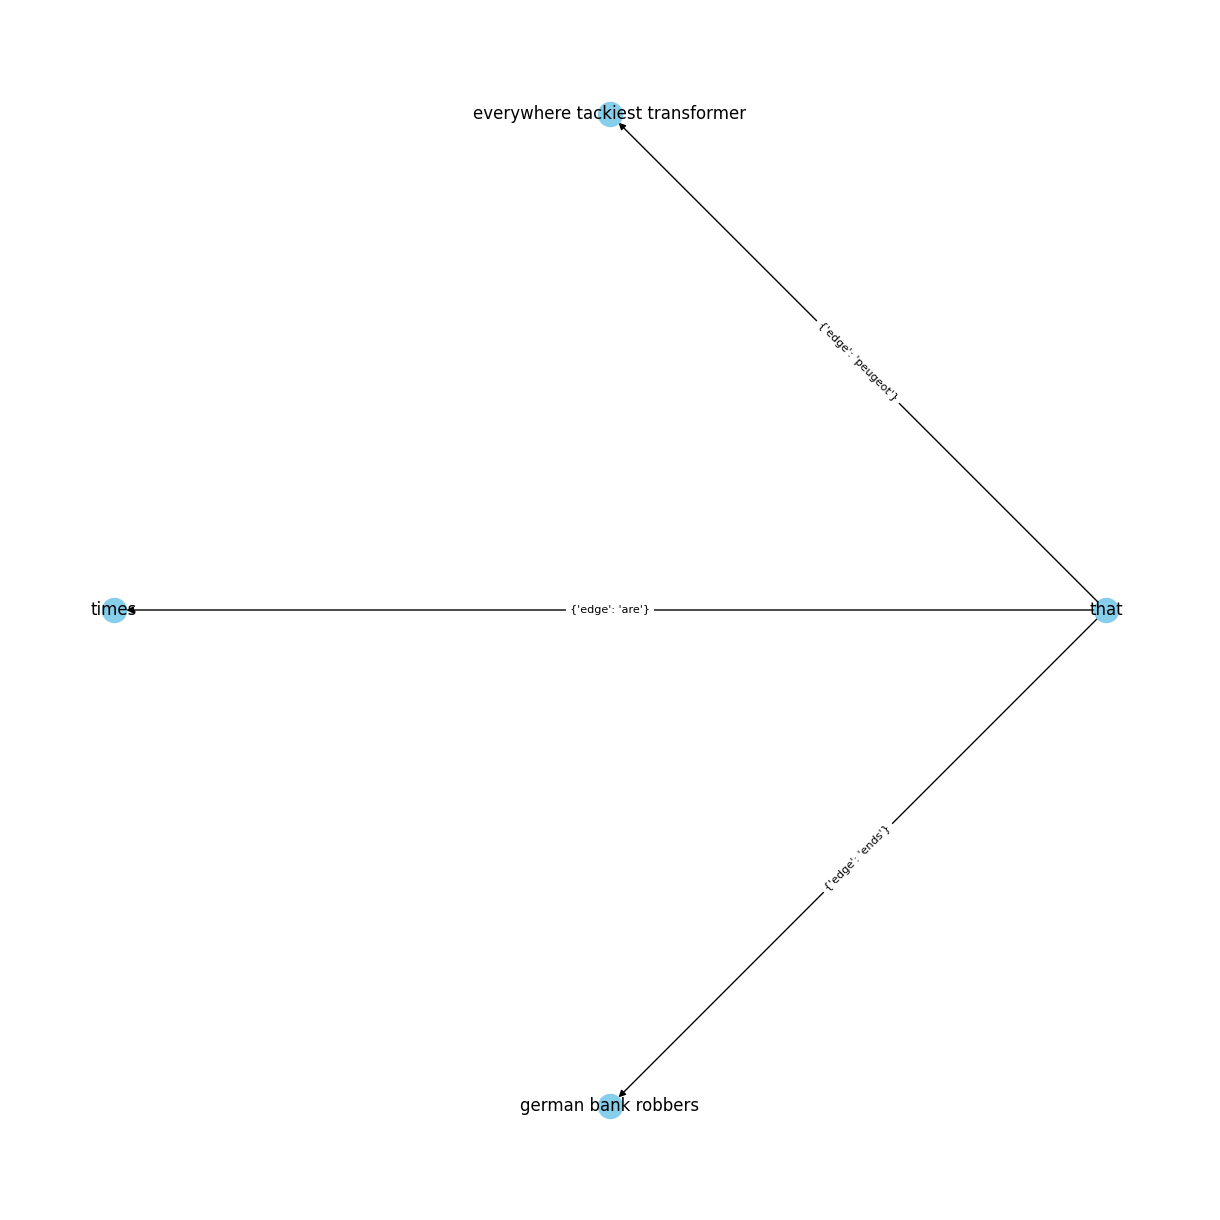

Plotting knowledge graph of "source" token "soundtrack":


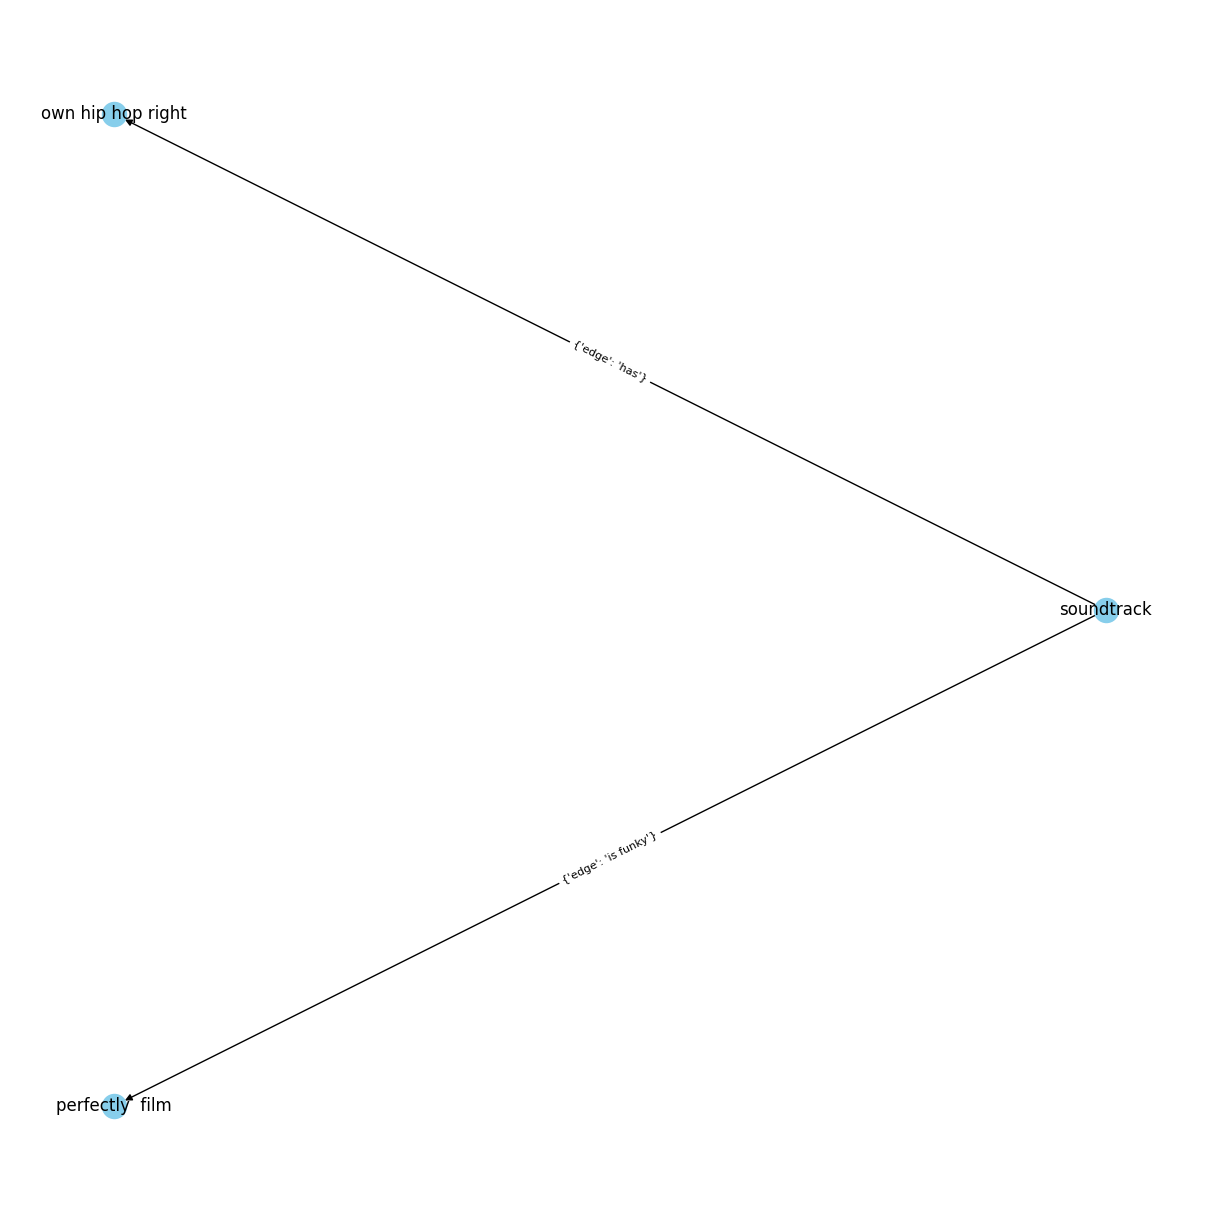

Plotting knowledge graph of "source" token "this":


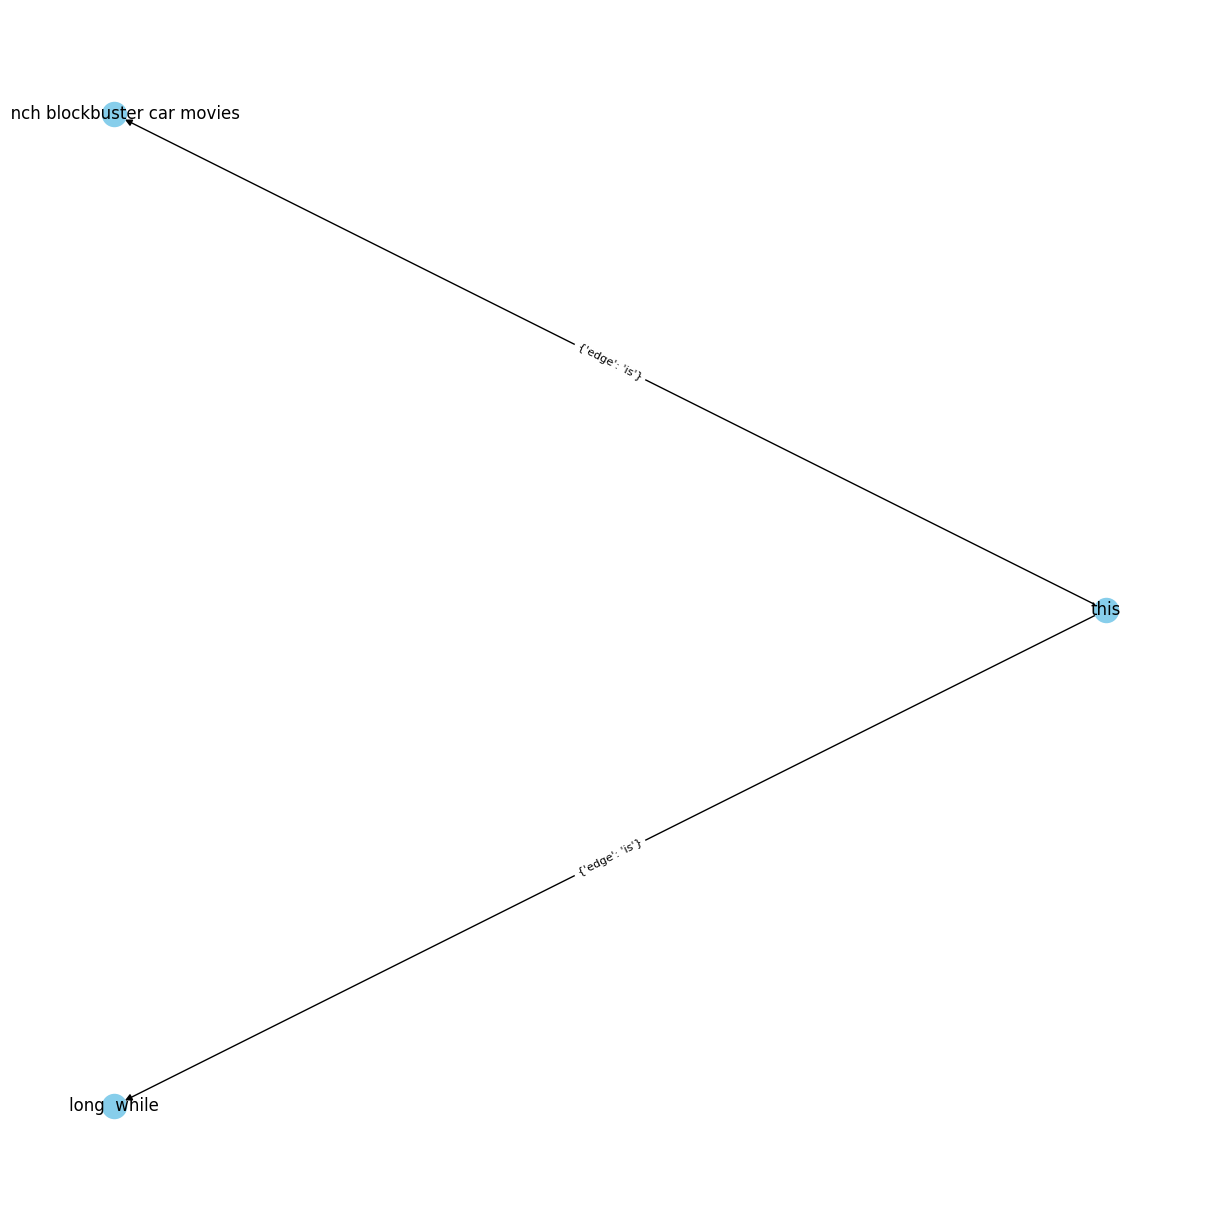

Plotting knowledge graph of "target" token "film":


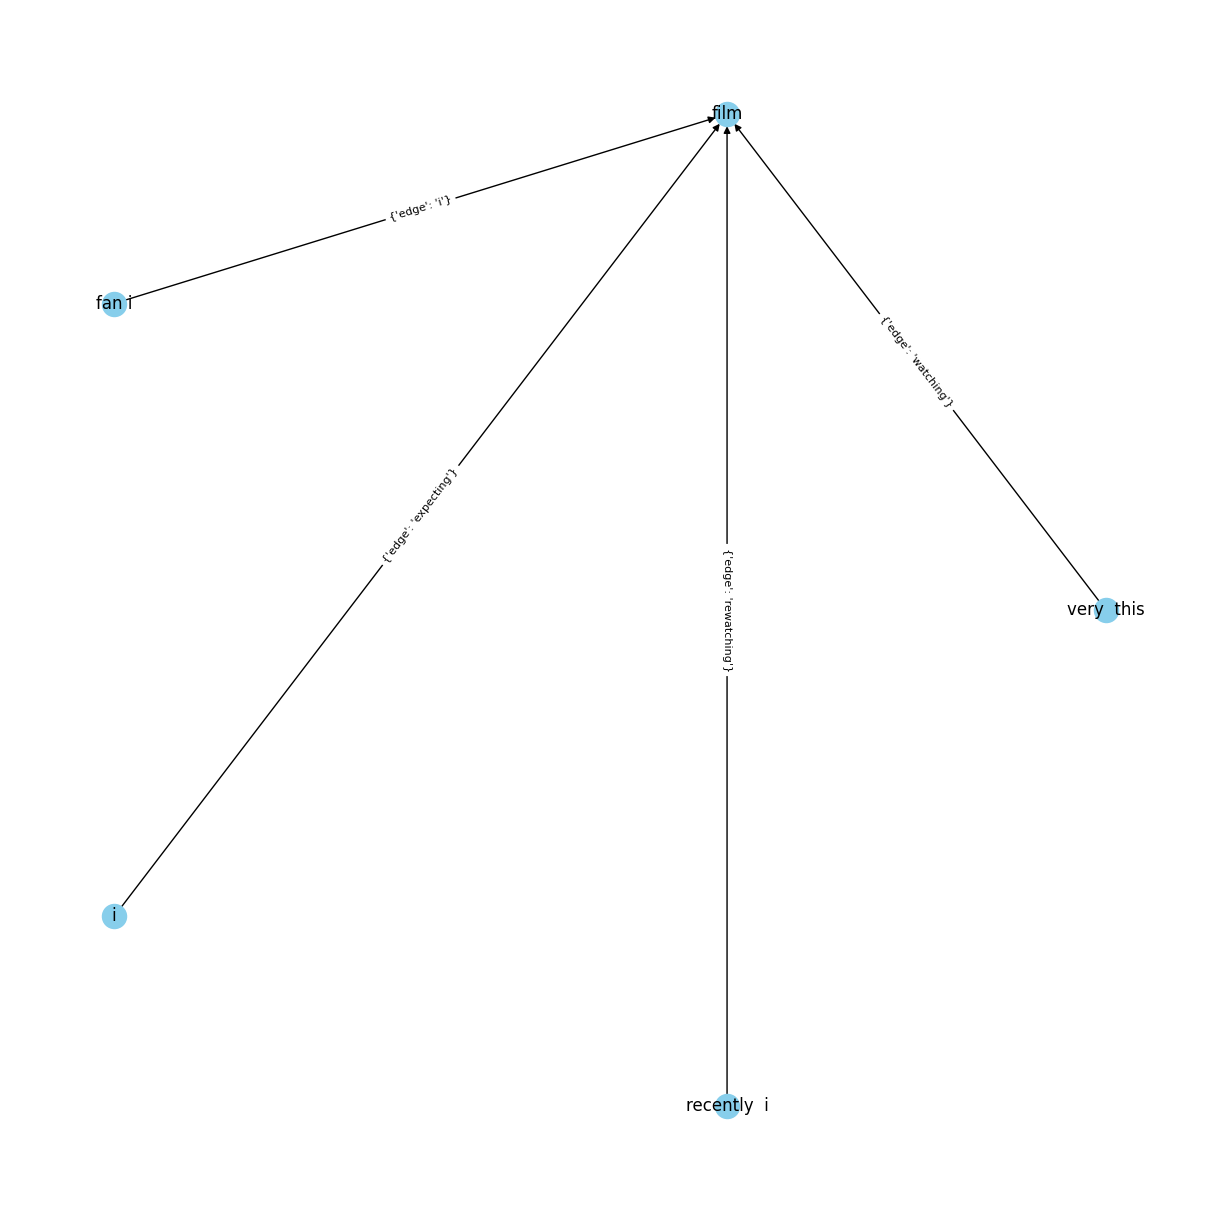

Plotting knowledge graph of "target" token "movie":


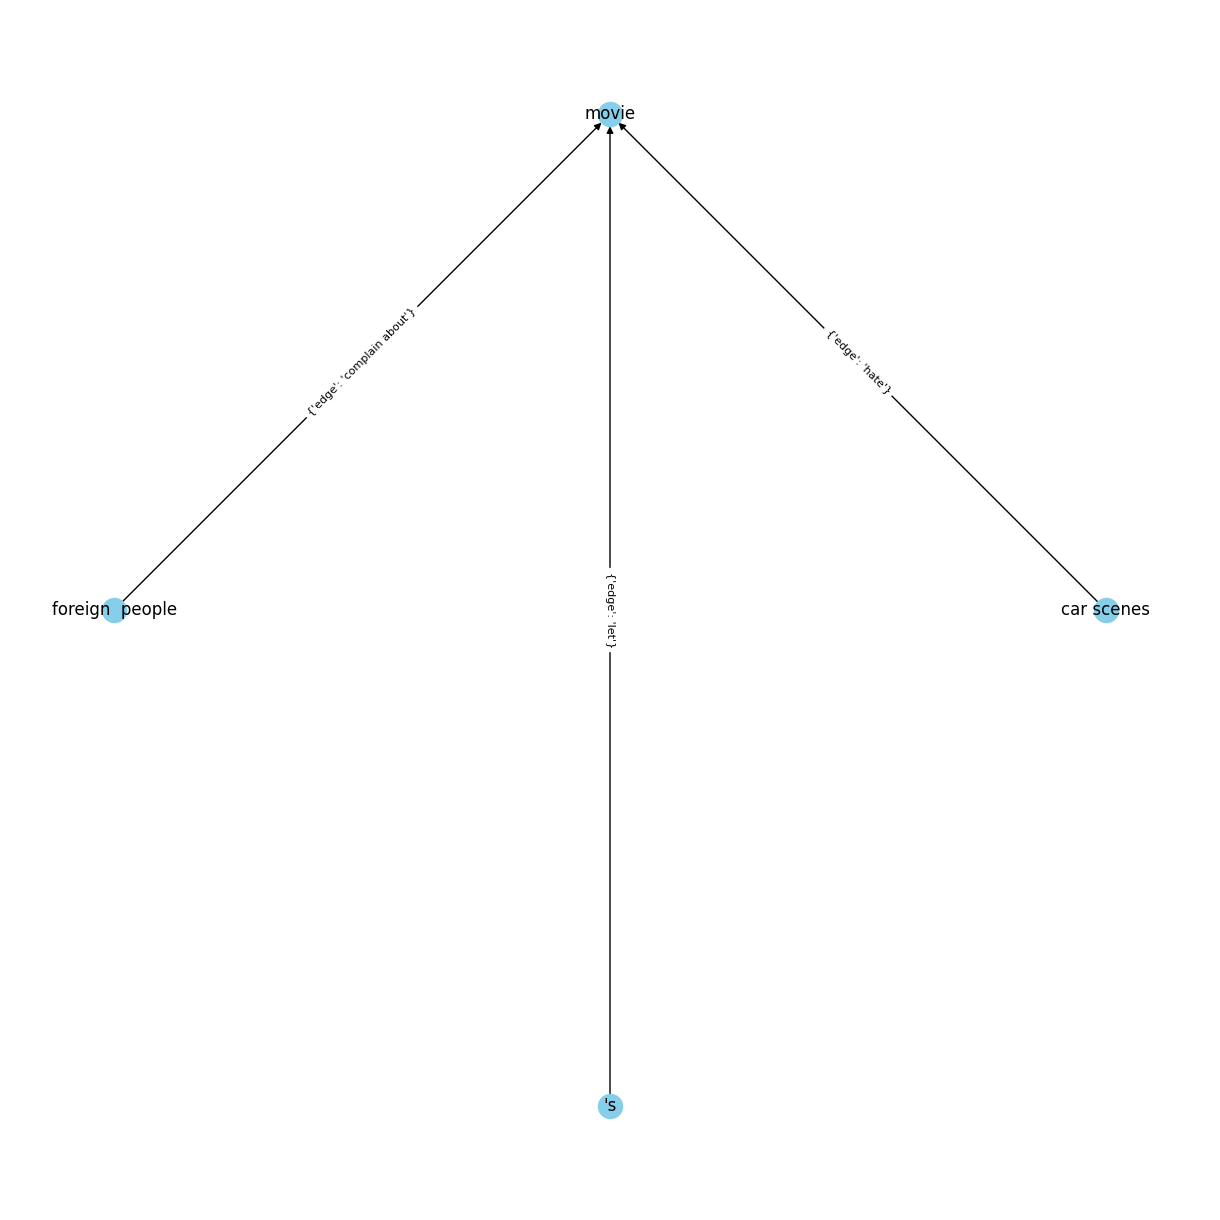

Plotting knowledge graph of "target" token "it":


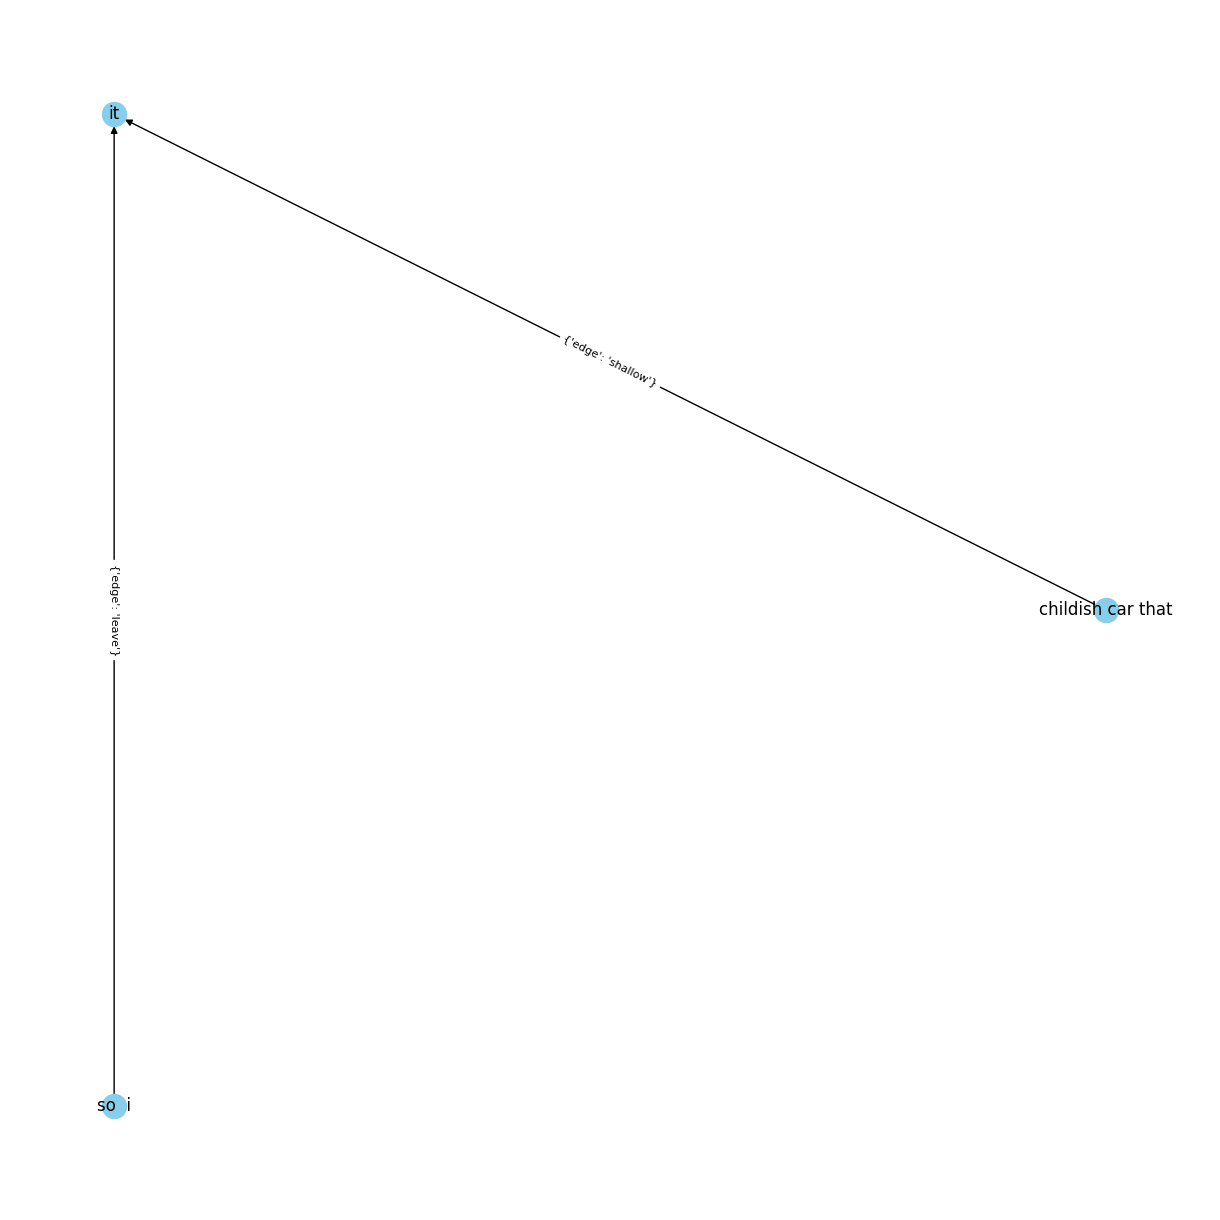

Plotting knowledge graph of "target" token "you":


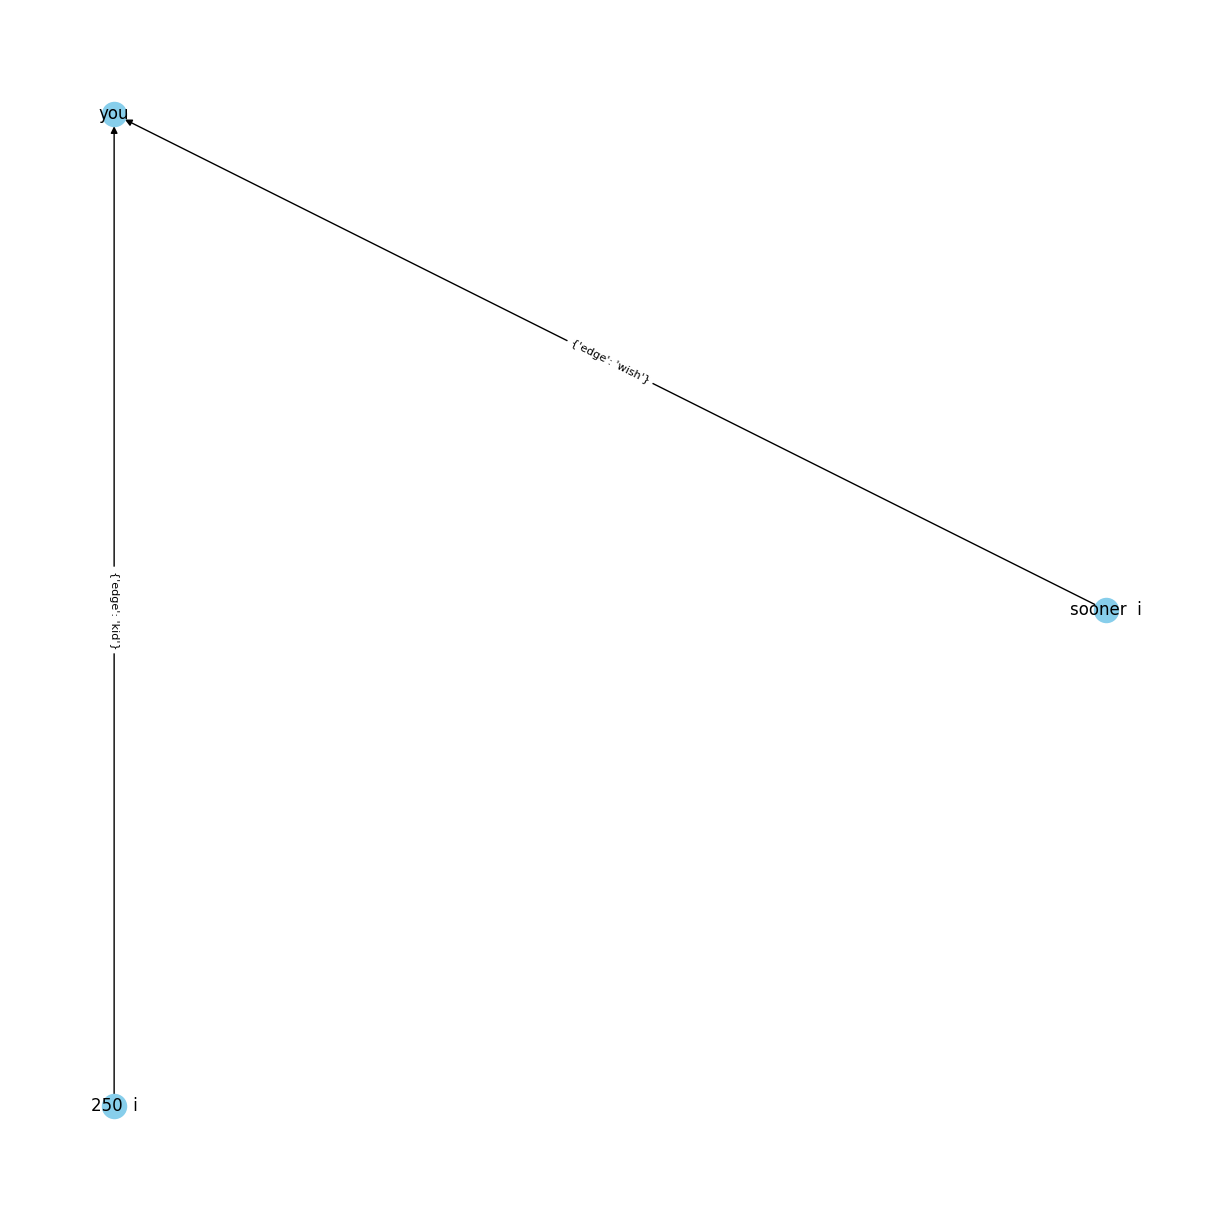

Plotting knowledge graph of "target" token "way":


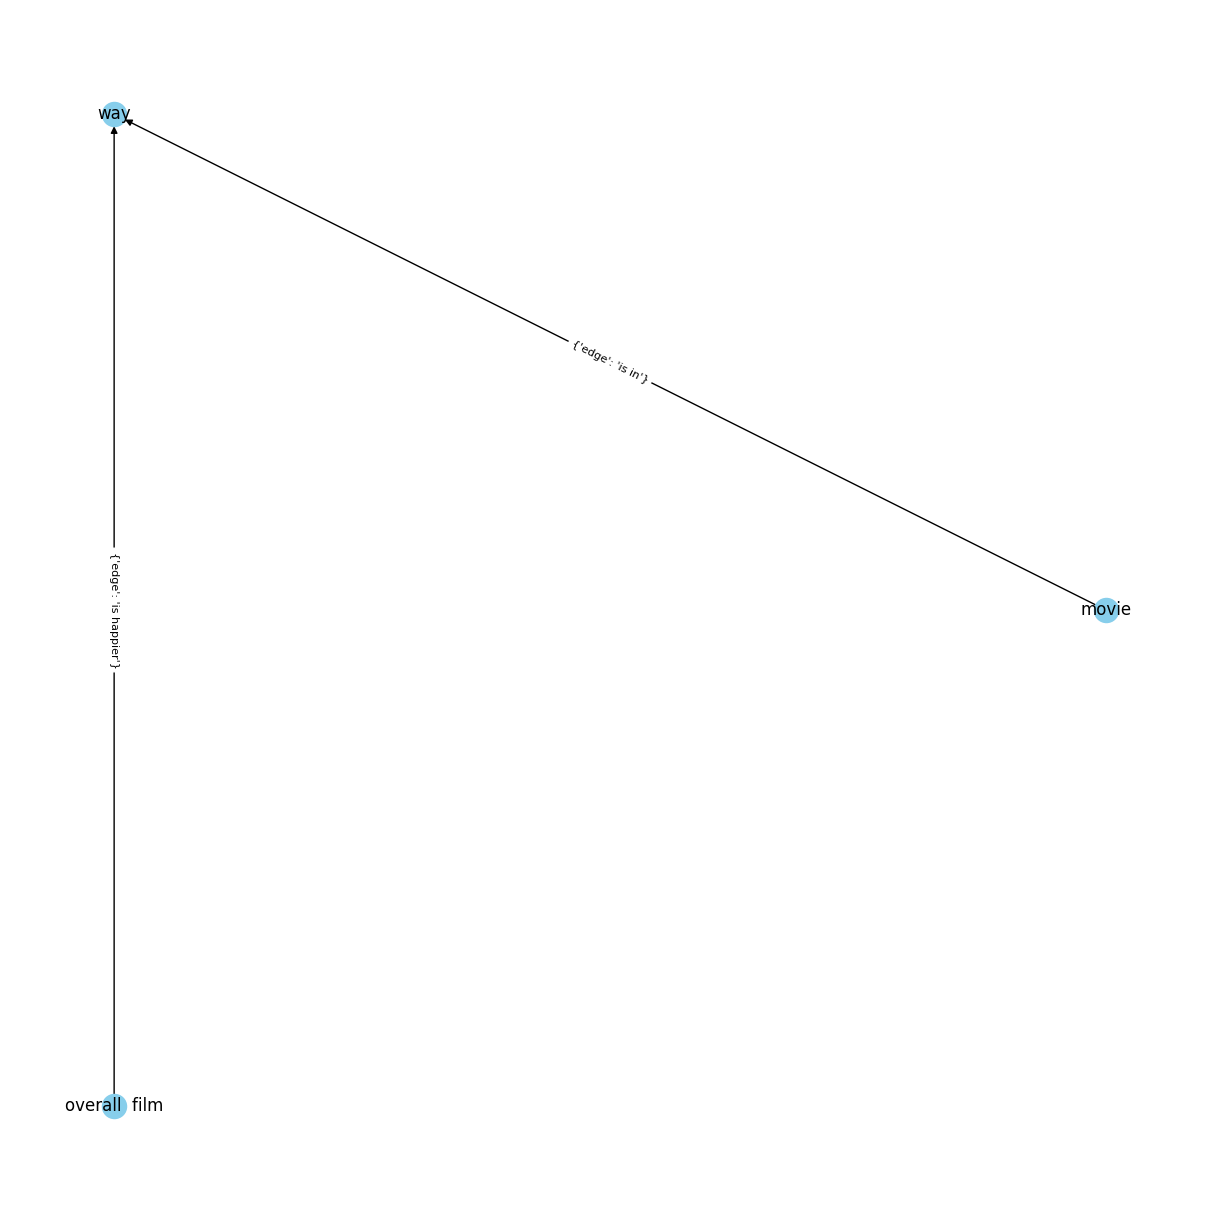

Plotting knowledge graph of "target" token "well  what":


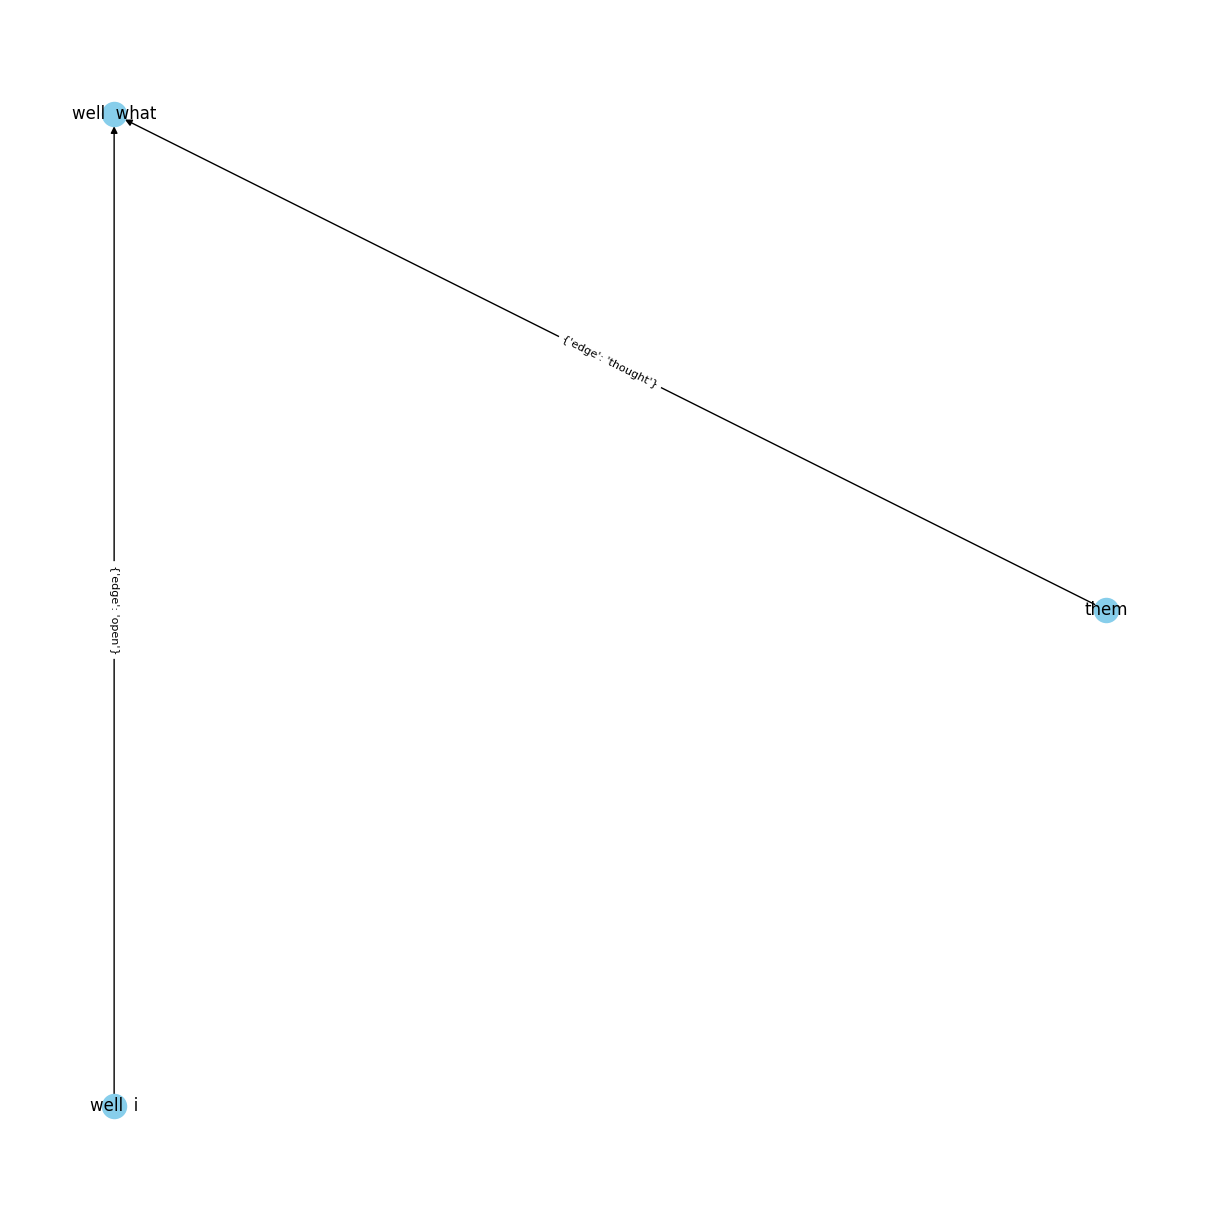

Plotting knowledge graph of "target" token "german bank robbers":


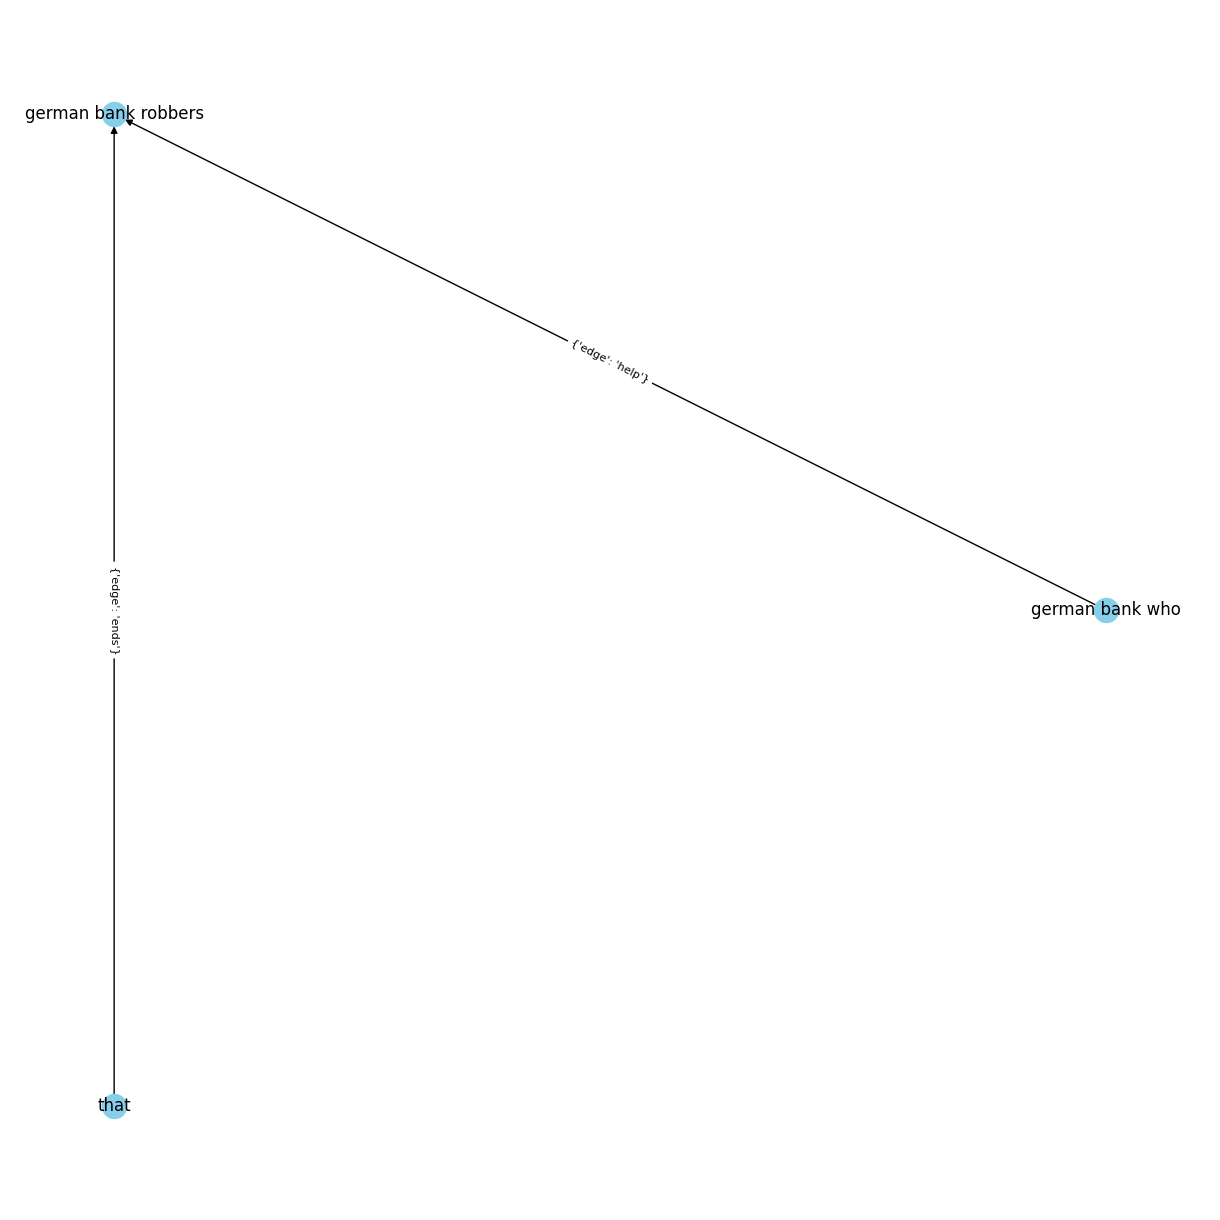

Plotting knowledge graph of "target" token "cars":


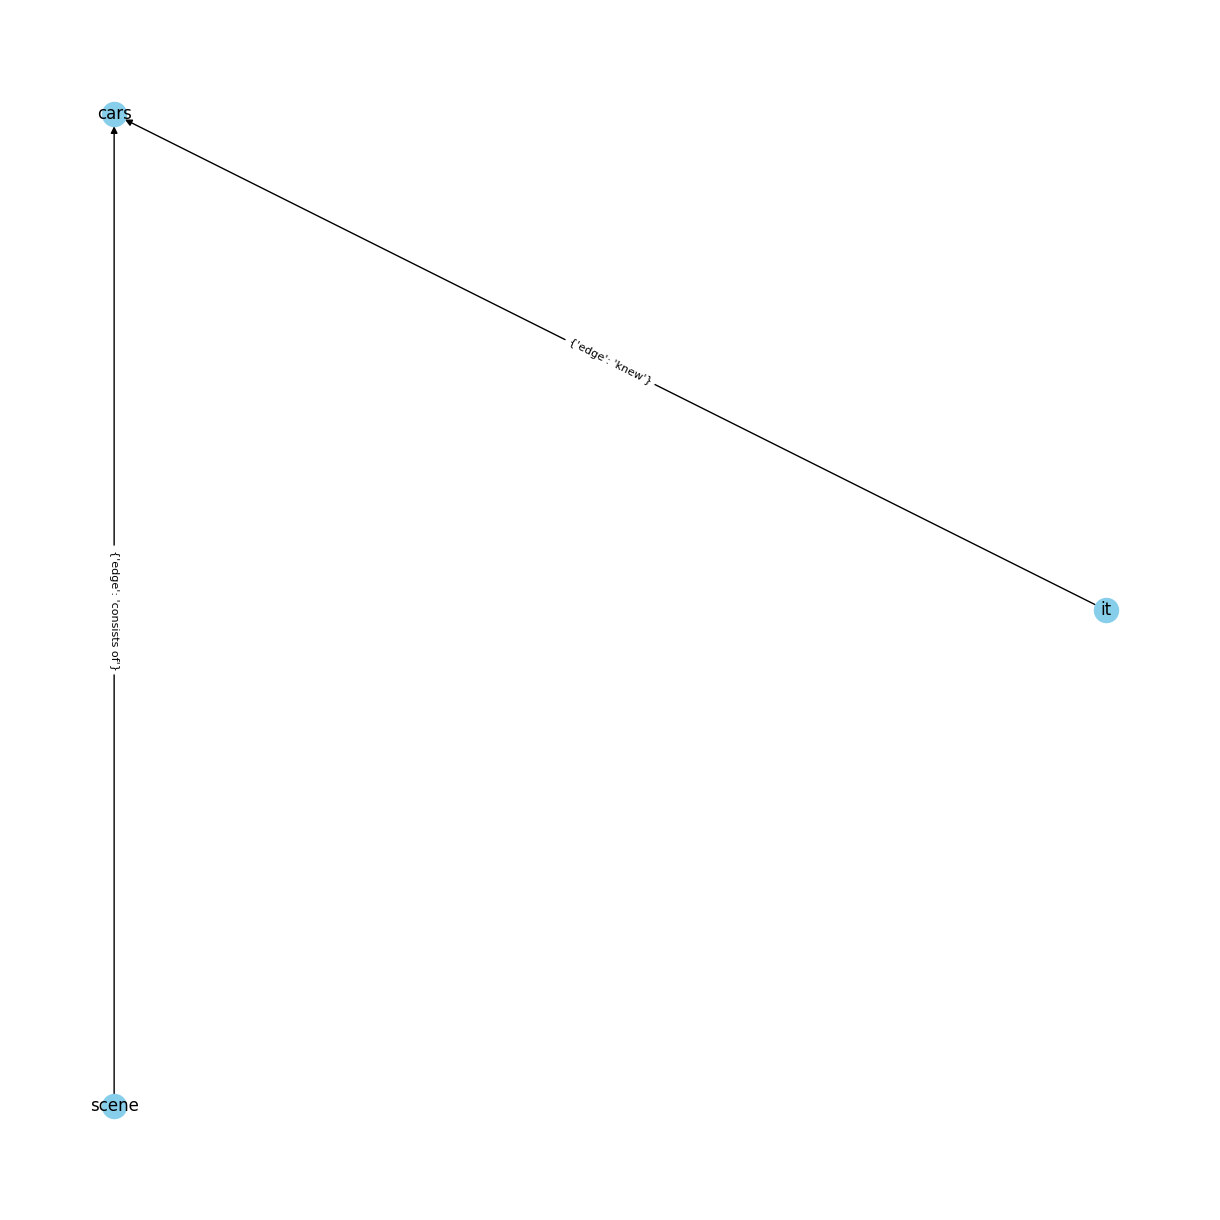

Plotting knowledge graph of "target" token "what":


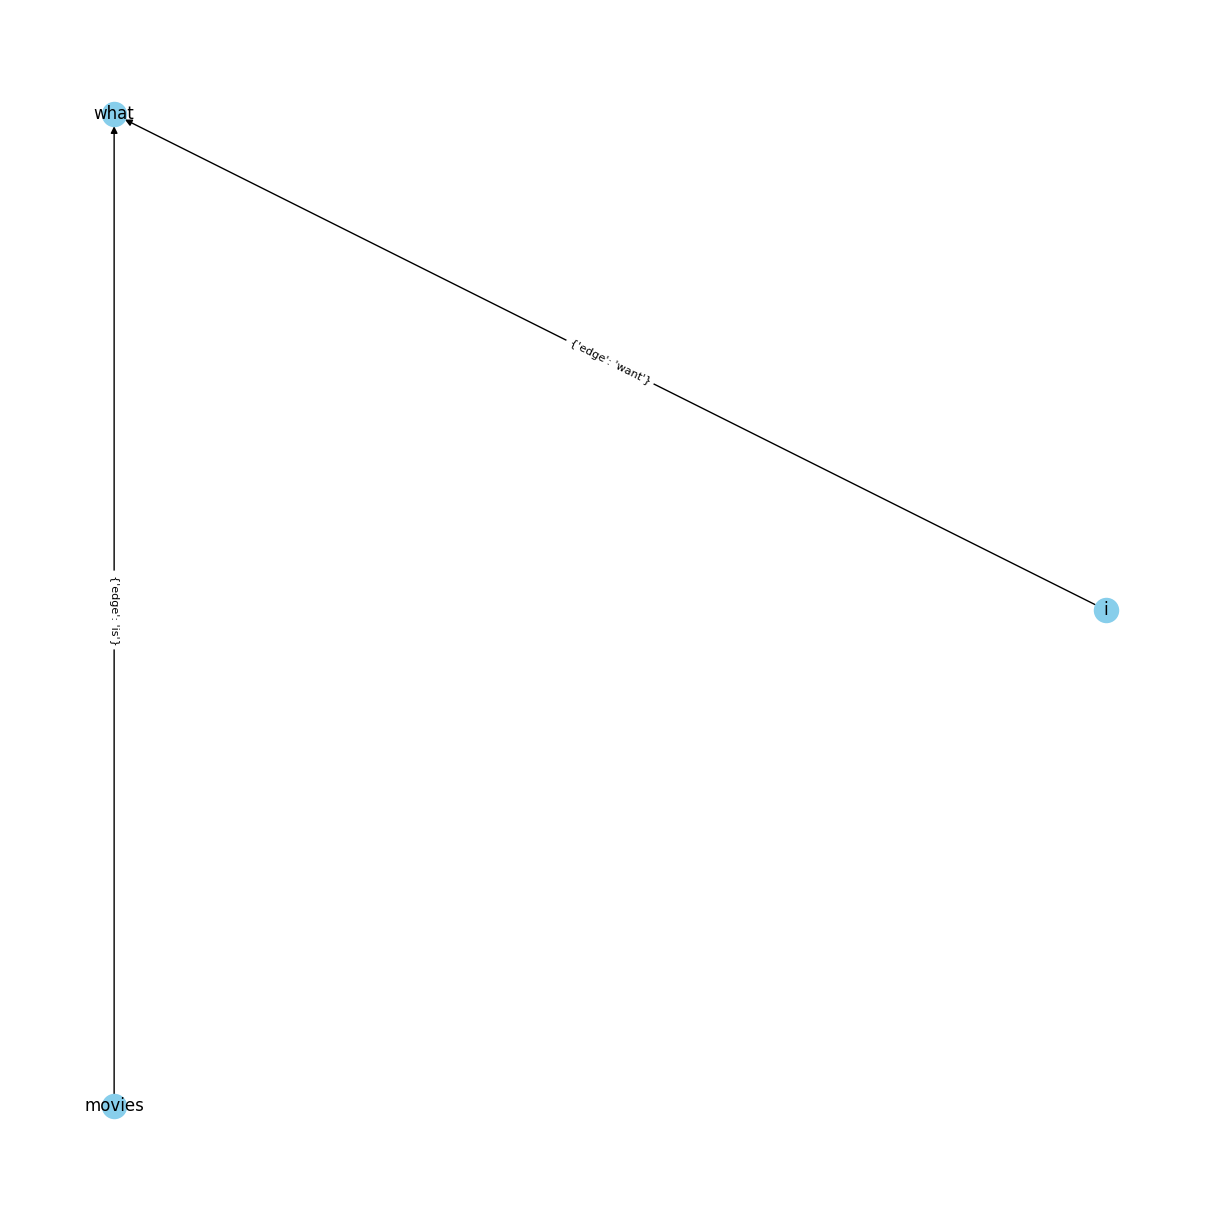

Plotting knowledge graph of "target" token "few  years":


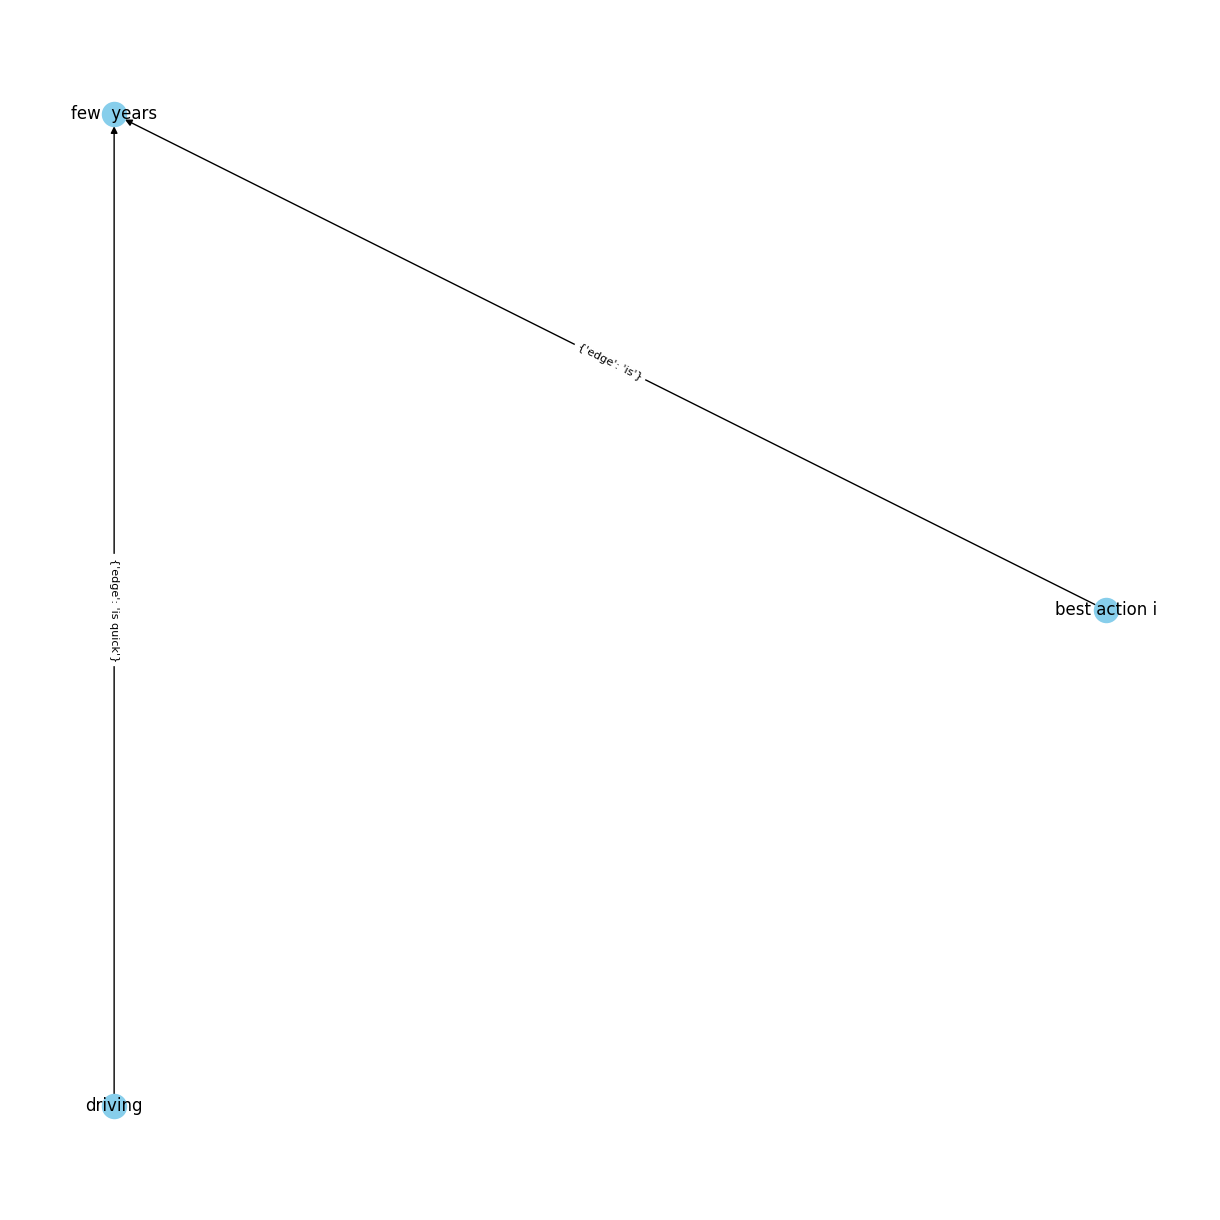

Plotting knowledge graph of "edge" token "is":


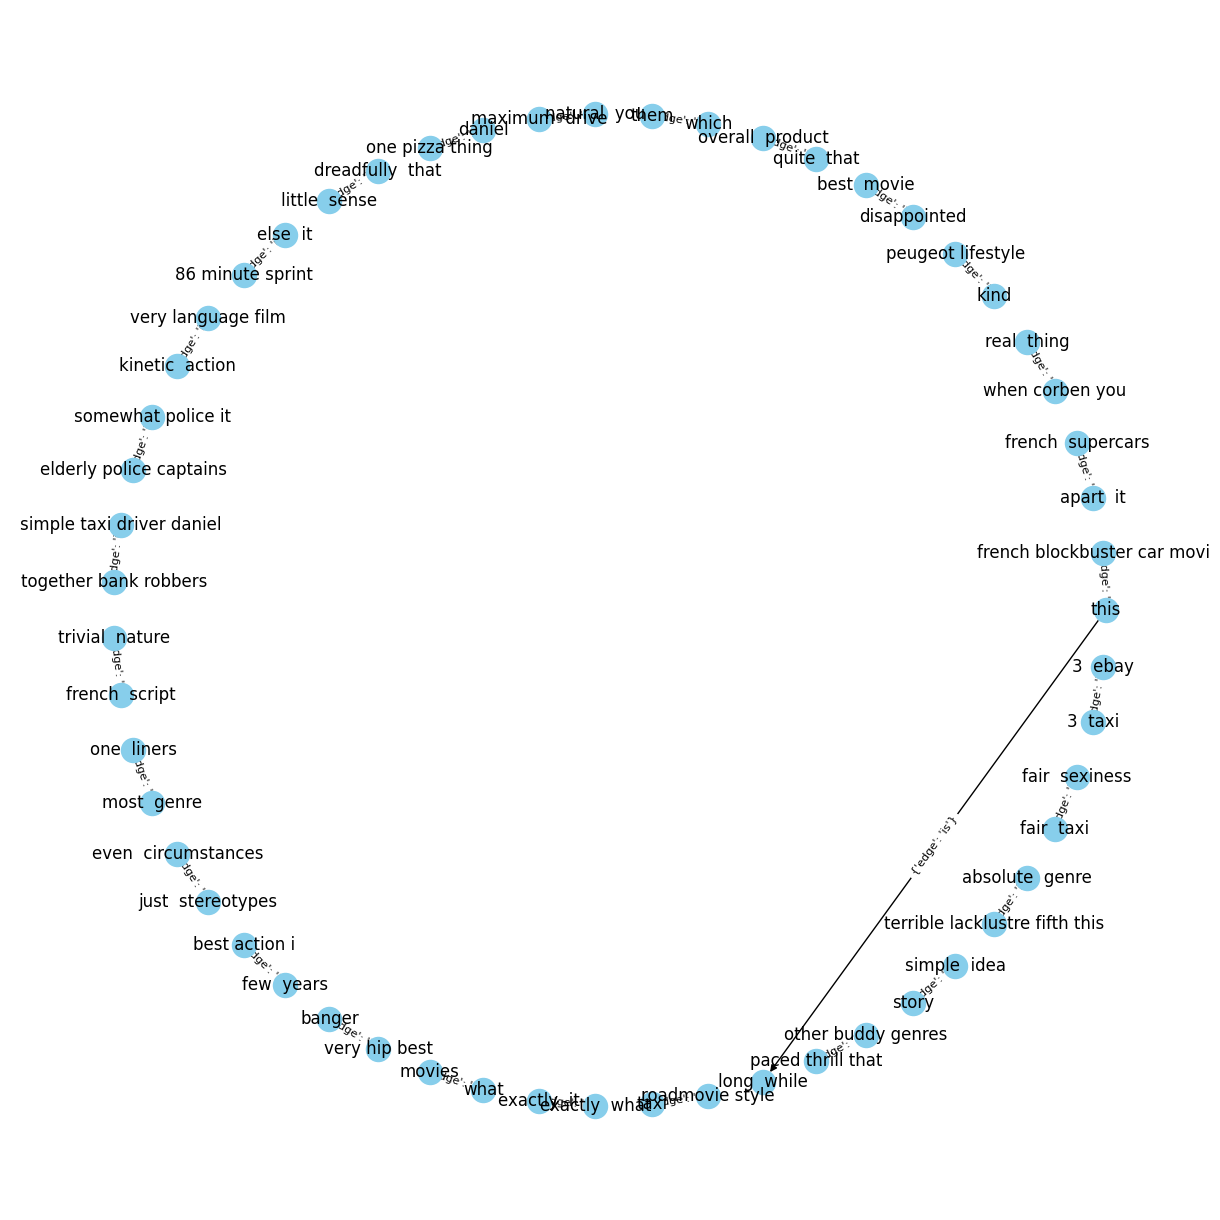

Plotting knowledge graph of "edge" token "are":


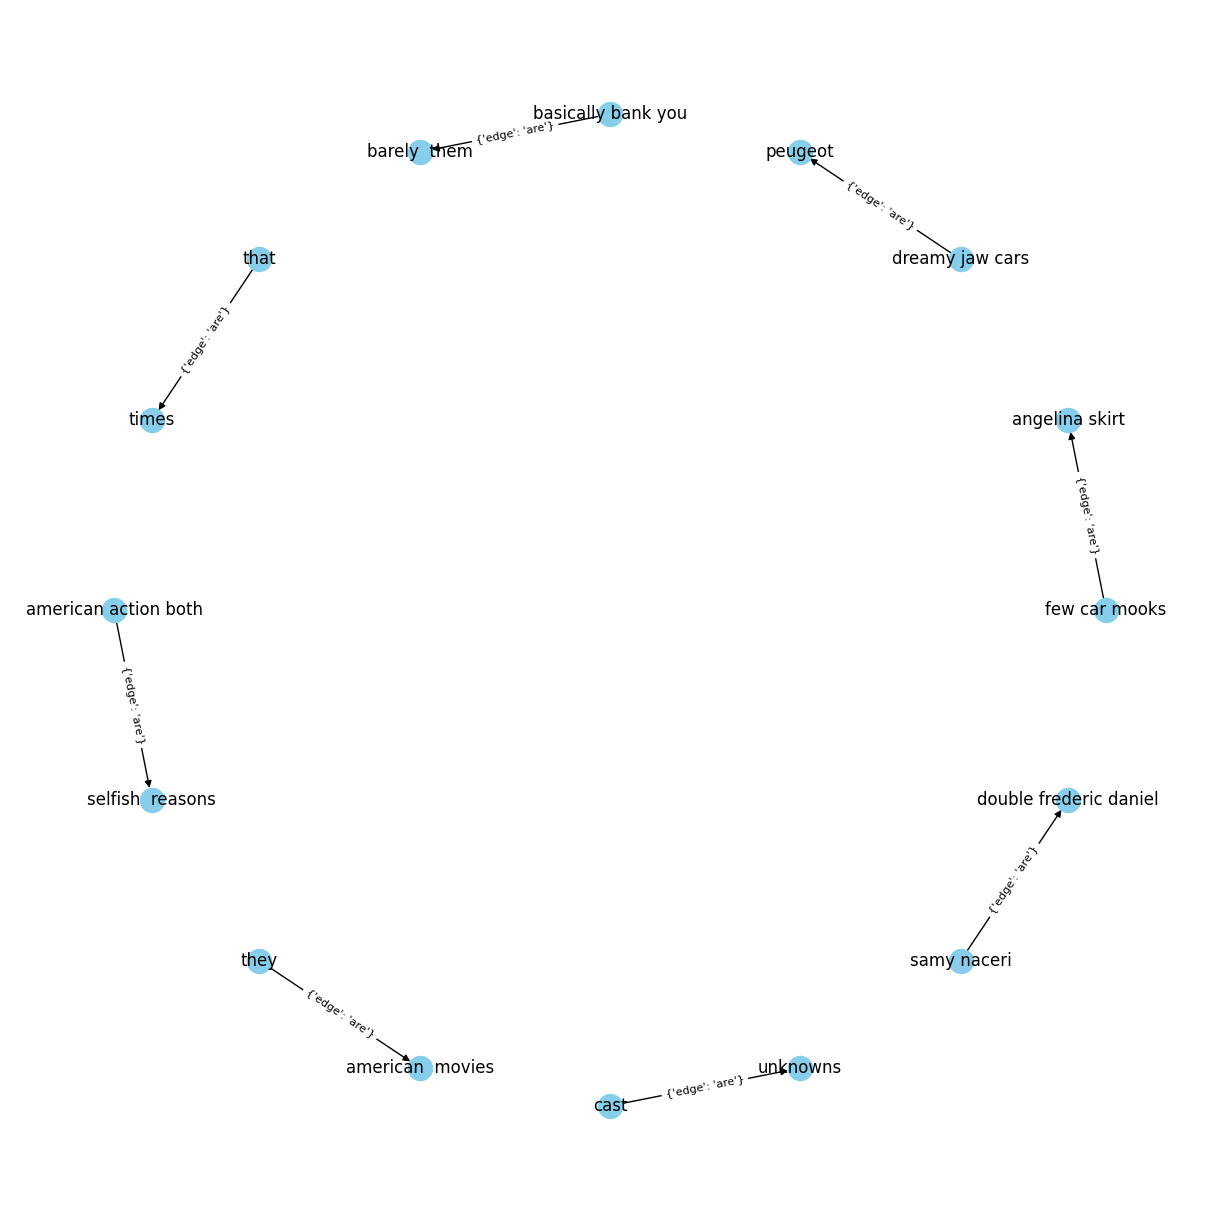

Plotting knowledge graph of "edge" token "has":


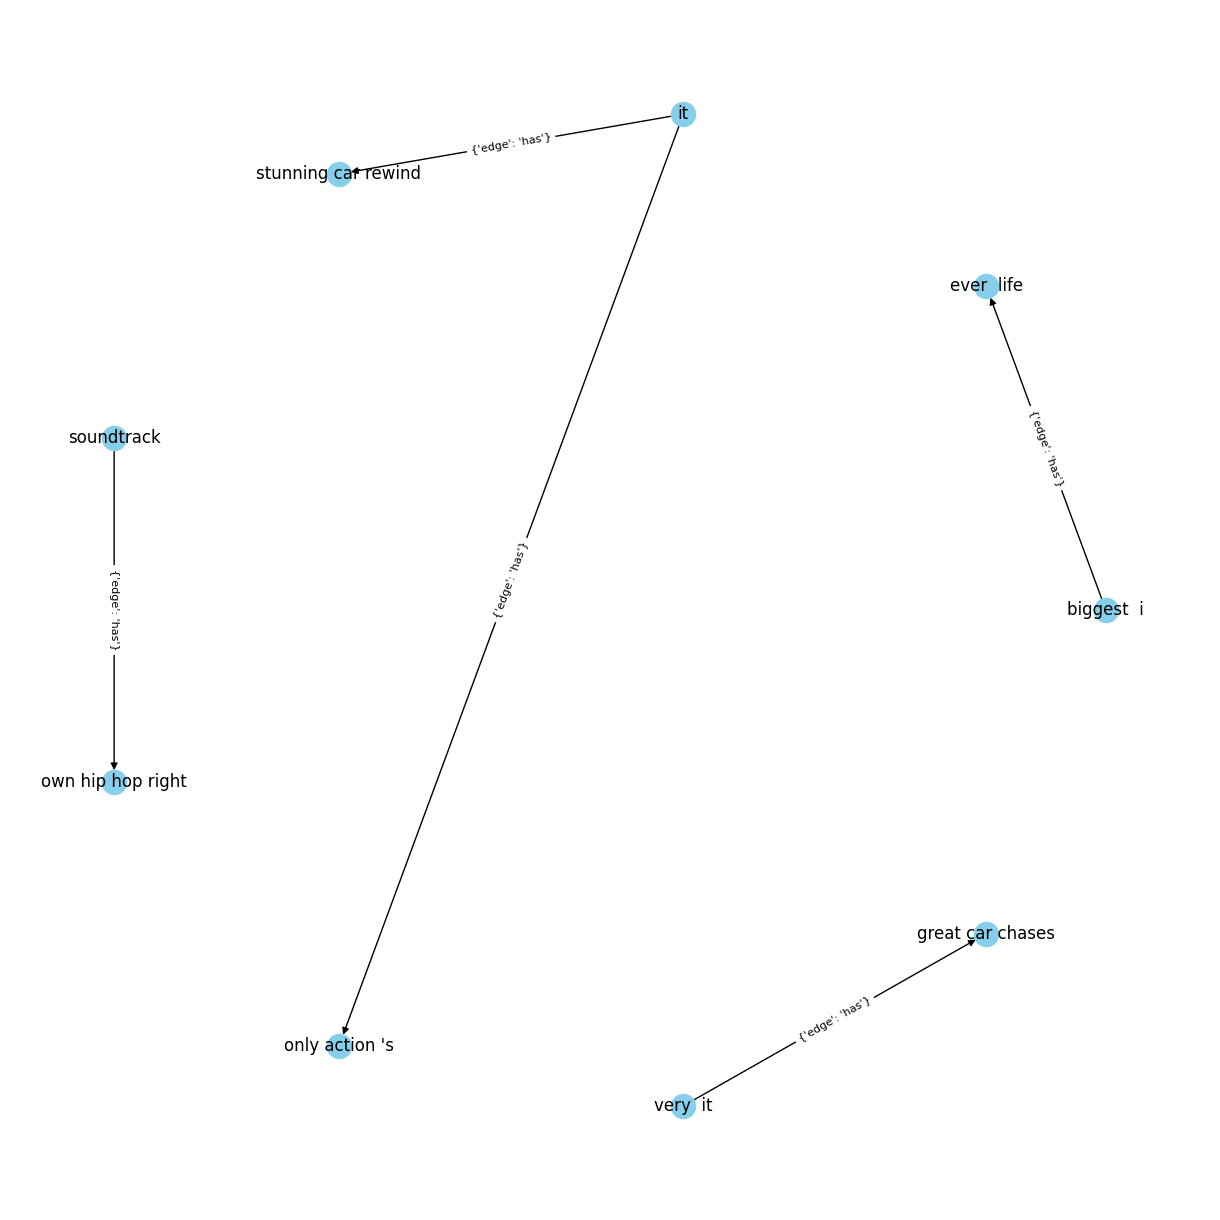

Plotting knowledge graph of "edge" token "recommend":


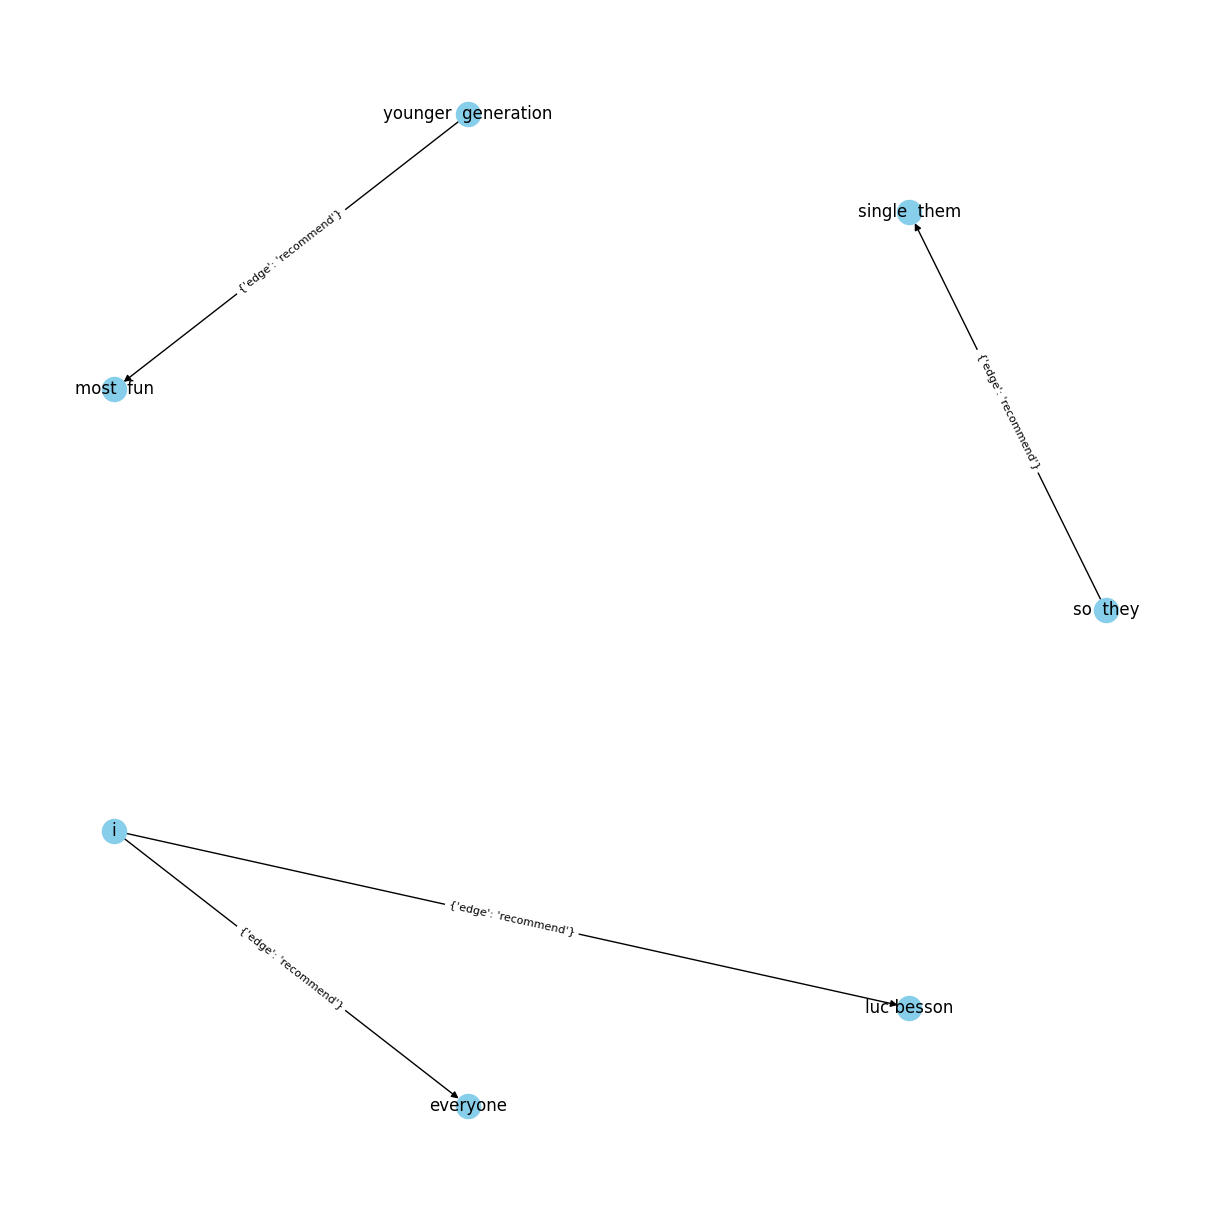

Plotting knowledge graph of "edge" token "get":


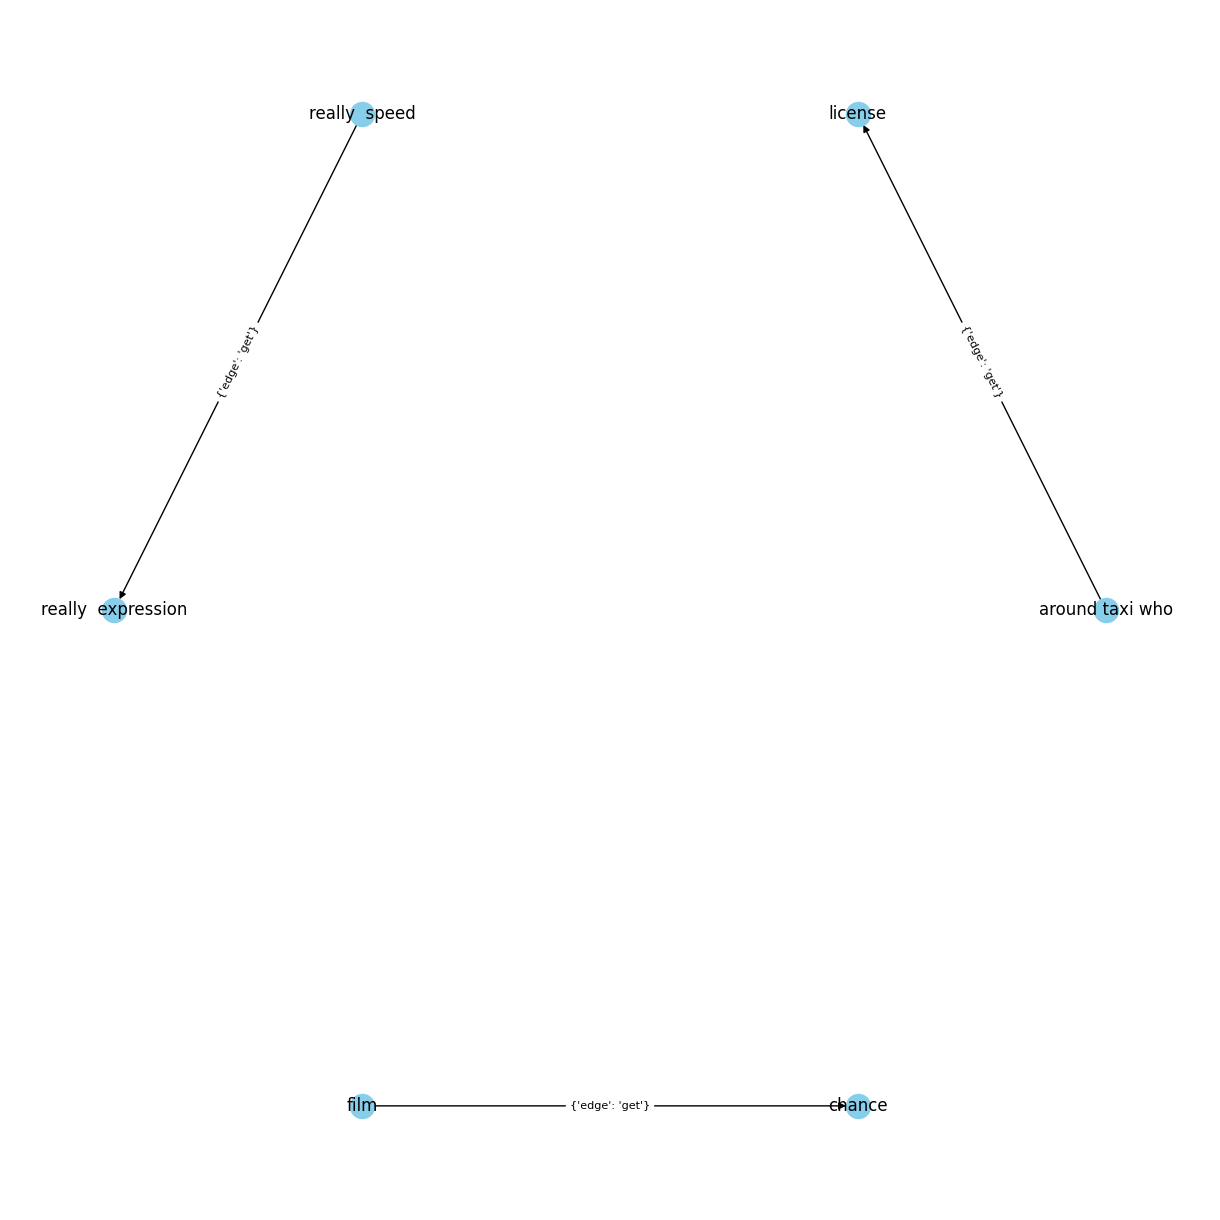

Plotting knowledge graph of "edge" token "want":


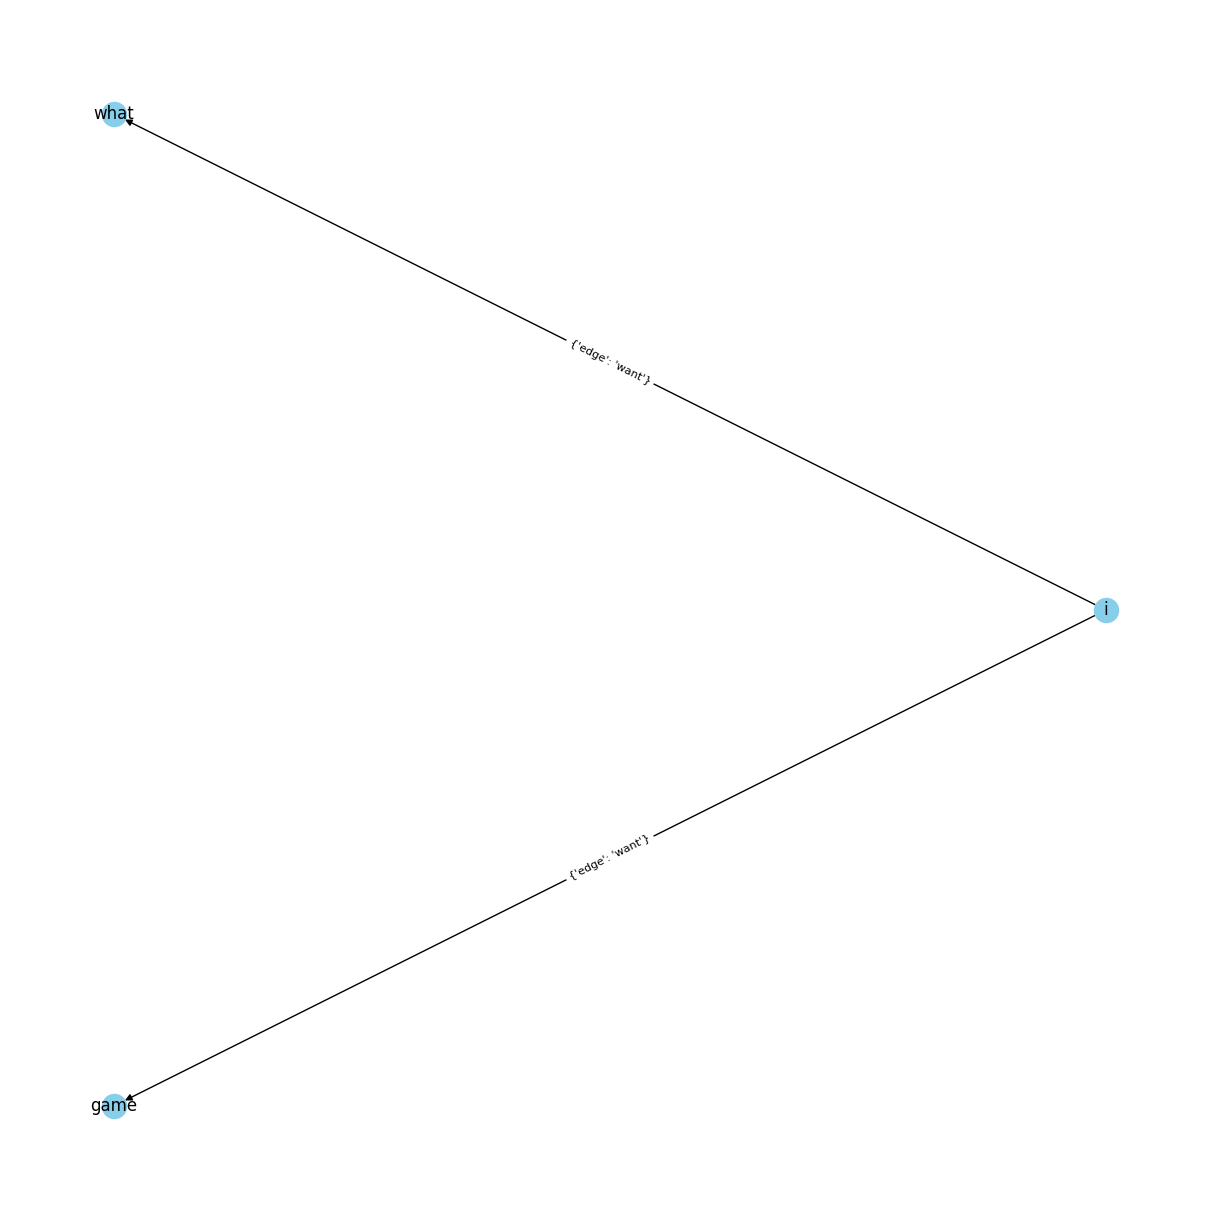

Plotting knowledge graph of "edge" token "consists of":


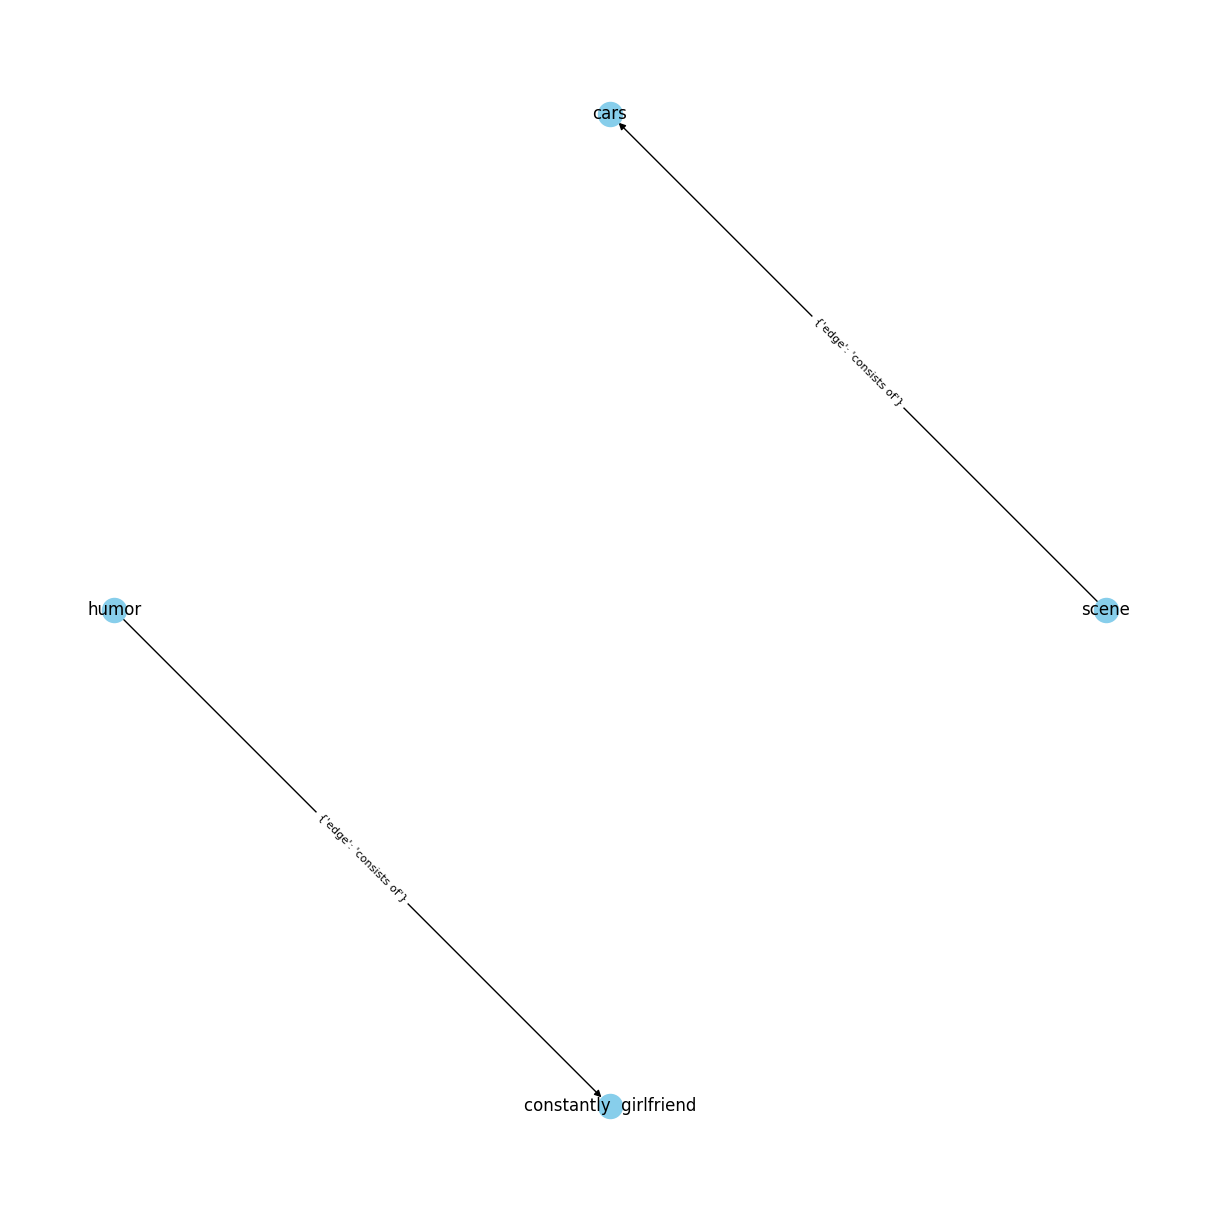

Plotting knowledge graph of "edge" token "give":


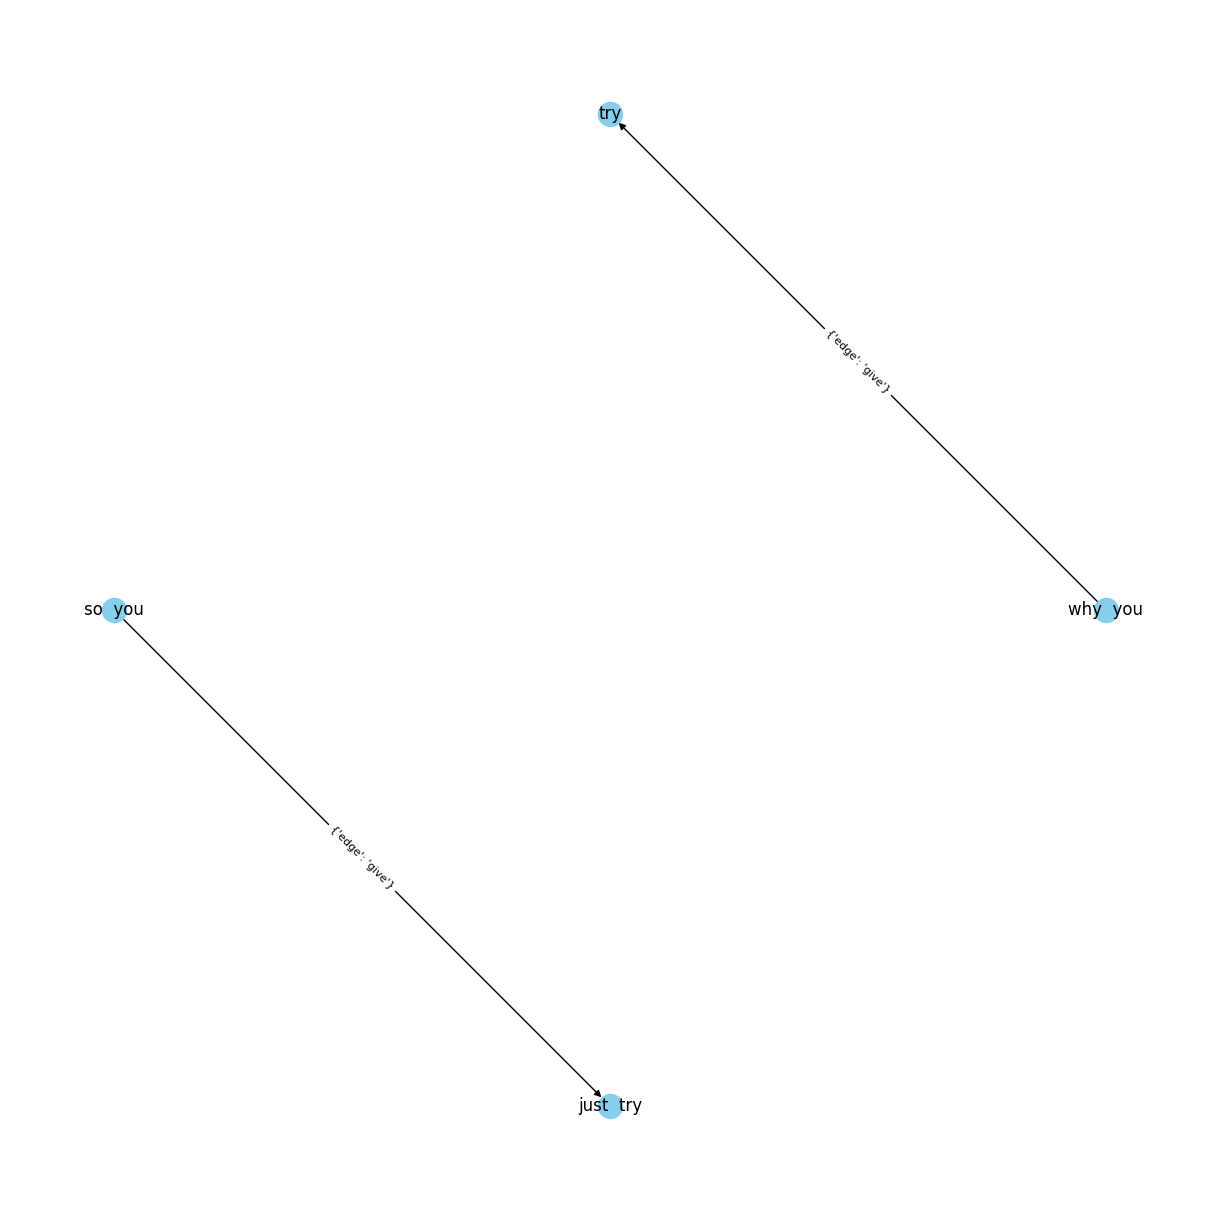

Plotting knowledge graph of "edge" token "was":


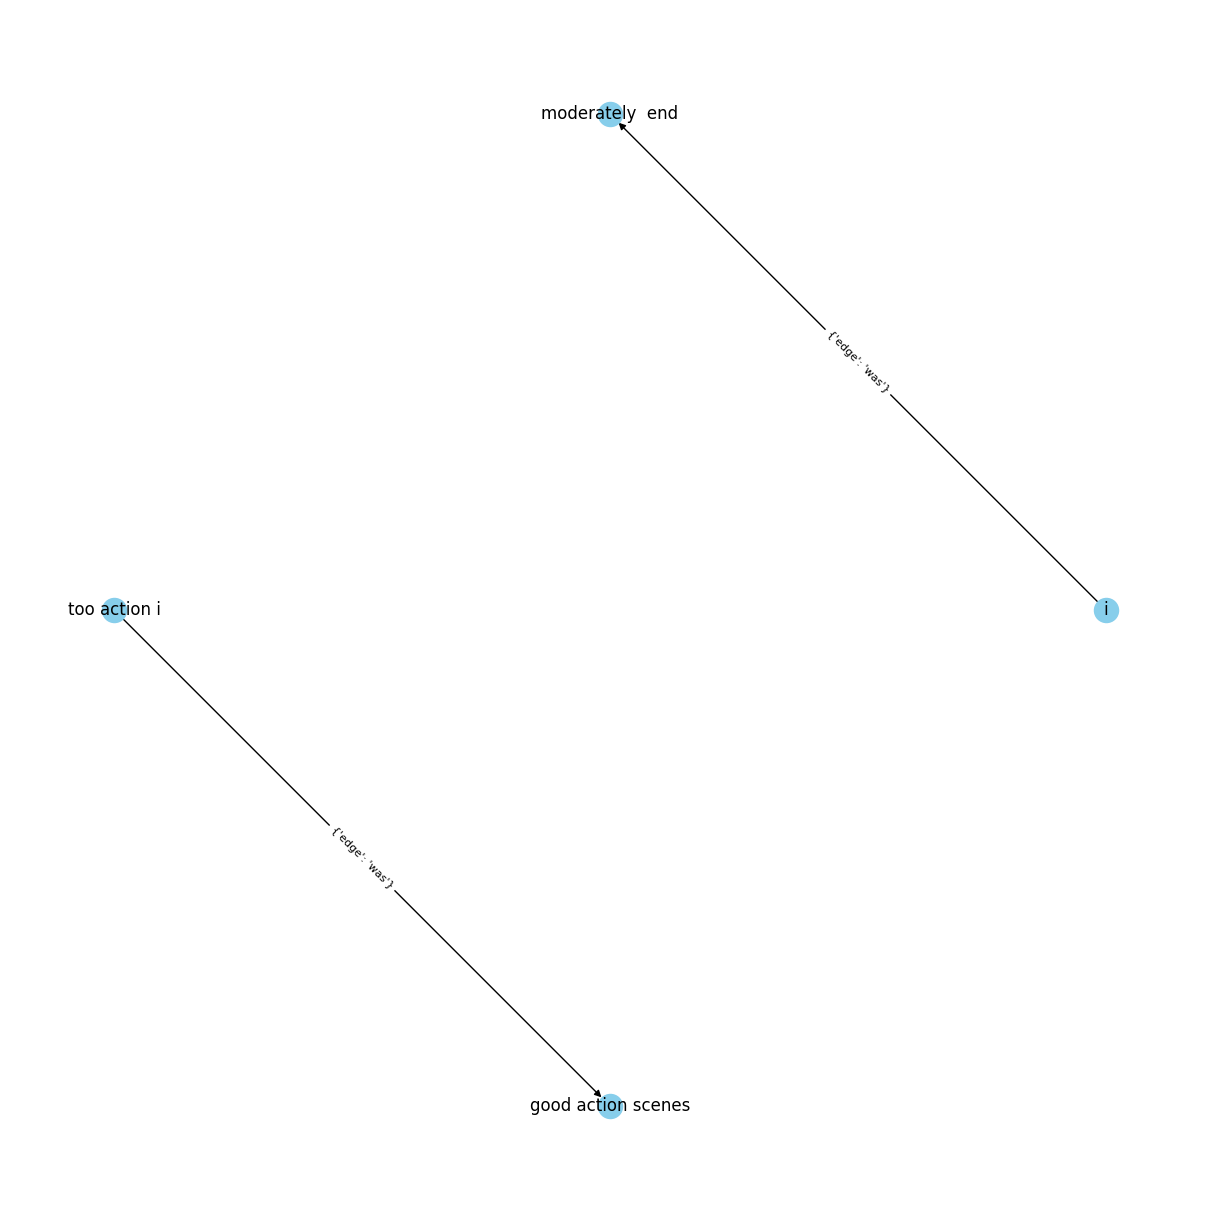

Plotting knowledge graph of "edge" token "wish":


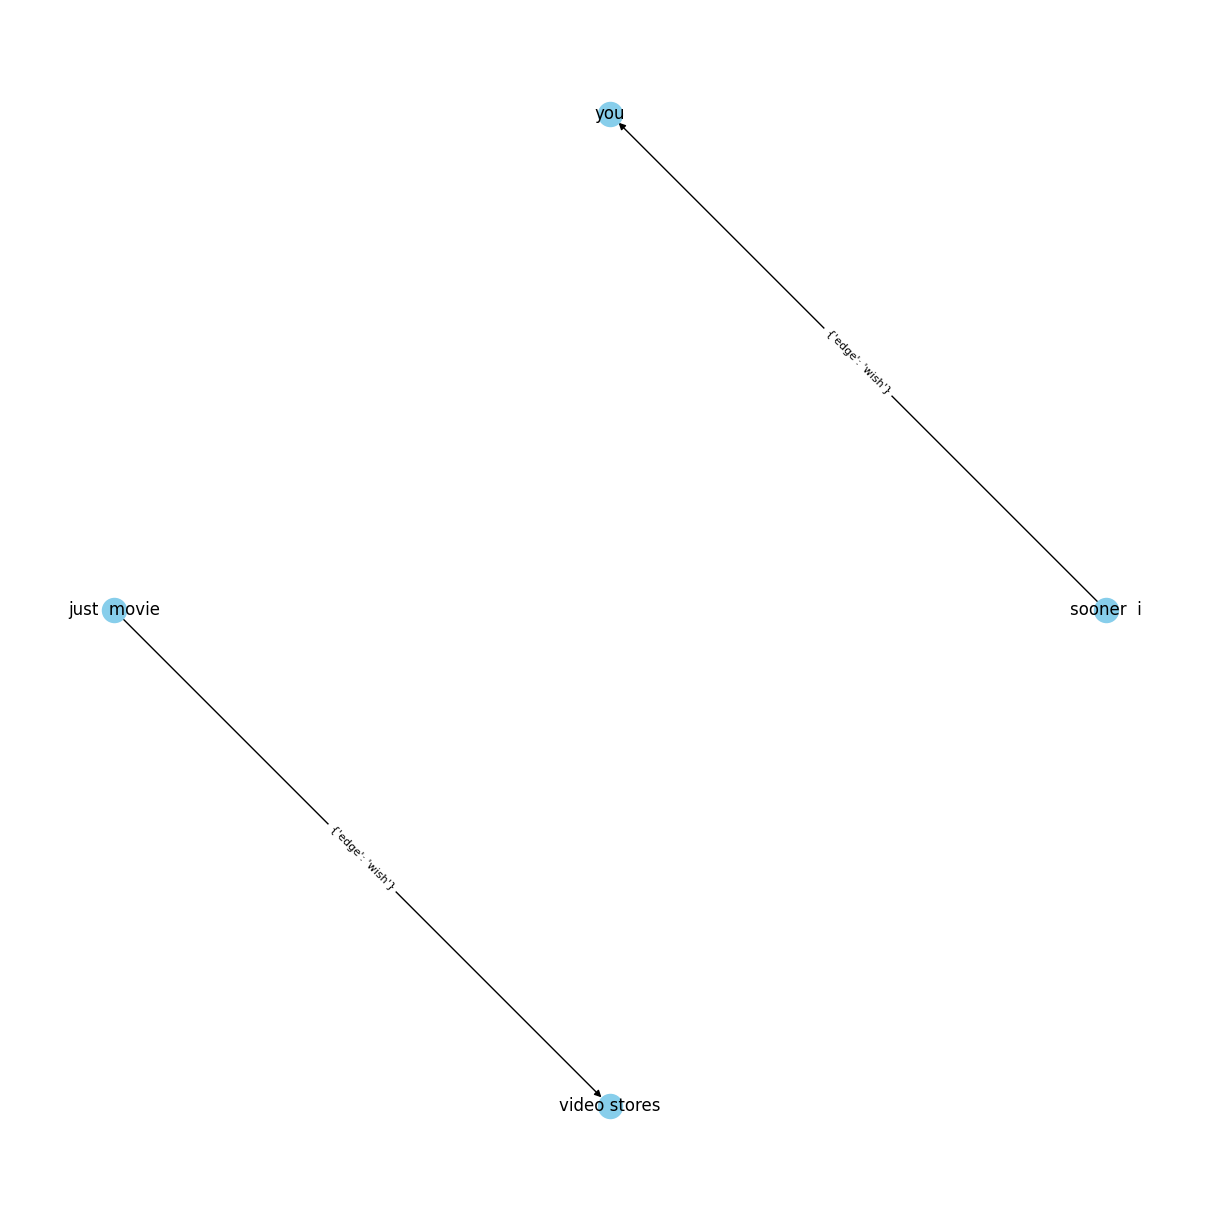

In [191]:
subset_item_list = ['source', 'target', 'edge']
no_of_sub_items = 10
for subset in subset_item_list:
  for key in kg_df[subset].value_counts().keys()[:no_of_sub_items].tolist():
    print(f"Plotting knowledge graph of \"{subset}\" token \"{key}\":")
    subset_df = kg_df[kg_df[subset]==key]
    plot_graph(subset_df, use_circular=True, show_edges=True)